# Data Sources

Get data 

## import

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
import yfinance as yf
import ccxt
from openbb_terminal.sdk import openbb

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()



Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://docs.openbb.co/sdk/quickstart/installation/

## definitions

In [2]:
#yf_eth = yf.Ticker("ETH-USD")
#yf_btc = yf.Ticker("BTC-USD")

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
API_GLASSNODE_KEY = os.getenv("API_GLASSNODE_KEY")
openbb.keys.glassnode(key=os.getenv("API_GLASSNODE_KEY"))
openbb.keys.messari(key=os.getenv("API_MESSARI_KEY"))
ETH_TICK = "ETH/USDT"
BTC_TICK = "BTC/USDT"
BNB_TICK = "BNB/USDT"
FIRST_DATE = "2023-01-01 00:00:00"
LAST_DATE =  "2023-06-07 07:00:00"
TIMEFRAME = "5m"
PATH_DATA = "data"
path_save_df_eth = "data/df_eth_05m.csv"
path_save_df_eth_2 = "data/df_eth_2_05m.csv"
path_save_df_btc = "data/df_btc_05m.csv"
path_save_df_btc_2 = "data/df_btc_2_05m.csv"
path_save_df_bnb = "data/df_bnb_05m.csv"
path_save_df_bnb_2 = "data/df_bnb_2_05m.csv"
path_save_df_eco = "data/df_eco.csv"
path_save_df_feat = "data/df_feat_05m.csv"

# CCXT crypto exchanges declaration
exchange = ccxt.binance({
    'rateLimit': 1000,
    'enableRateLimit': True,
})

kucoin = ccxt.kucoin({
    'rateLimit': 1,
    'enableRateLimit': True,
})


## Download data

In [3]:
ohlcvs = exchange.fetch_ohlcv(ETH_TICK, TIMEFRAME)
ohlcvs

[[1685971800000, 1866.64, 1869.52, 1866.63, 1868.72, 1189.6908],
 [1685972100000, 1868.72, 1869.44, 1867.65, 1867.84, 1011.8304],
 [1685972400000, 1867.85, 1869.48, 1867.41, 1868.85, 822.6724],
 [1685972700000, 1868.86, 1869.77, 1867.23, 1867.62, 810.5149],
 [1685973000000, 1867.61, 1868.0, 1866.69, 1868.0, 416.2393],
 [1685973300000, 1868.0, 1868.59, 1867.22, 1867.47, 457.3113],
 [1685973600000, 1867.47, 1871.16, 1866.64, 1871.15, 1493.5738],
 [1685973900000, 1871.15, 1871.2, 1867.08, 1867.48, 1178.2684],
 [1685974200000, 1867.48, 1867.82, 1864.77, 1864.77, 1690.4285],
 [1685974500000, 1864.78, 1866.49, 1863.73, 1866.13, 1093.4062],
 [1685974800000, 1866.14, 1868.08, 1866.06, 1867.74, 989.9869],
 [1685975100000, 1867.73, 1868.17, 1866.57, 1866.85, 618.7146],
 [1685975400000, 1866.86, 1868.04, 1865.37, 1868.04, 847.0049],
 [1685975700000, 1868.04, 1868.26, 1866.8, 1866.89, 770.6329],
 [1685976000000, 1866.88, 1868.37, 1866.16, 1868.36, 790.556],
 [1685976300000, 1868.37, 1869.57, 1868.

In [4]:
ohlcvs[0][0]

1685971800000

In [5]:
ohlcvs[-1][0]

1686121500000

In [6]:
ohlcvs[-1][0] - ohlcvs[0][0]

149700000

In [7]:
len(ohlcvs)

500

In [8]:
(ohlcvs[-1][0] - ohlcvs[0][0]) / (len(ohlcvs)-1)

300000.0

In [9]:
300000.0 / (60*1000)

5.0

In [10]:
# params
#ticker = ETH_TICK
#from_datetime = FIRST_DATE
#to_datetime = LAST_DATE

# def
def req_ohlcv(
        exchange,
        ticker,
        timeframe,
        from_datetime,  
        to_datetime=None
    ):
    
    # common constants
    msec = 1000
    minute = 60 * msec
    hour = 60 * minute
    hold = 30

    from_timestamp = exchange.parse8601(from_datetime)

    if to_datetime is None:
        to_timestamp = exchange.milliseconds()
    else:
        to_timestamp = exchange.parse8601(to_datetime)
        

    data = []

    while from_timestamp < to_timestamp:

        try:

            print(exchange.milliseconds(), 'Fetching candles starting from', exchange.iso8601(from_timestamp))
            ohlcvs = exchange.fetch_ohlcv(ticker, timeframe, from_timestamp, params= { 'until': to_timestamp})
            print(exchange.milliseconds(), 'Fetched', len(ohlcvs), 'candles')
            first = ohlcvs[0][0]
            last = ohlcvs[-1][0]
            print('First candle epoch', first, exchange.iso8601(first))
            print('Last candle epoch', last, exchange.iso8601(last))
            timeframe_ms = int((last - first) / (len(ohlcvs)-1))
            from_timestamp += len(ohlcvs) * timeframe_ms
            data += ohlcvs

        except (ccxt.ExchangeError, ccxt.AuthenticationError, ccxt.ExchangeNotAvailable, ccxt.RequestTimeout) as error:

            print('Got an error', type(error).__name__, error.args, ', retrying in', hold, 'seconds...')
            time.sleep(hold)
    
    df = pd.DataFrame(data)
    df.columns = (["Time", "Open", "High", "Low", "Close", "Volume"])

    df['date'] = pd.to_datetime(df['Time'], unit='ms') # -> date object
    df['date'] = df['date'].dt.strftime("%Y-%m-%d %H:%M:%S") # -> String

    return df

def check_data():
    return (
        os.path.isfile(path_save_df_eth) &
        os.path.isfile(path_save_df_btc) &
        os.path.isfile(path_save_df_bnb)
    )

def check_data_2():
    return (
        os.path.isfile(path_save_df_eth_2) &
        os.path.isfile(path_save_df_btc_2) &
        os.path.isfile(path_save_df_bnb_2)
    )


def test_time_continuity(df):
    try:
        assert df.shape[0] == df.dropna().shape[0], "Some data are NaN !"
        diff_time = df["Time"].diff()
        assert np.max(diff_time) == np.min(diff_time), "Time gap!"

        return True
    
    except AssertionError as error:
        print(error)
        return False




    
def req_ohlcv_all(exchange, first_date=FIRST_DATE, last_date=LAST_DATE):

    df_eth = req_ohlcv(
        exchange,
        ETH_TICK,
        TIMEFRAME,
        first_date,  
        last_date,
    )

    df_eth.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_btc = req_ohlcv(
            exchange,
            BTC_TICK,
            TIMEFRAME,
            first_date,  
            last_date,
    )

    df_btc.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)
 
    df_bnb = req_ohlcv(
            exchange,
            BNB_TICK,
            TIMEFRAME,
            first_date,  
            last_date,
    )

    df_bnb.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    return df_eth, df_btc, df_bnb

def merge_ohlcv_data(df_old, df_new):

    # Merge old with new data 
    df = pd.concat([df_old, df_new], ignore_index=True)
    print("df_old.shape: ", df_old.shape)
    print("df_new.shape: ", df_new.shape)
    print("Before : df.shape: ", df.shape)
    df = df.drop_duplicates(
        subset=["date"], keep="last", ignore_index=True)
    print("After : df.shape: ", df.shape)
    return df



def get_ohlcv_all(exchange, path_save_df_eth, path_save_df_btc, path_save_df_bnb):
    """
    Get prices from disk and from exchange if update needed
    """
    # reload from disk
    print("Reload data binance exchange from disk...")
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False)
    
    return df_eth, df_btc, df_bnb

In [11]:
data_ok = check_data()
print(data_ok)

if not data_ok:
    
    df_eth, df_btc, df_bnb = req_ohlcv_all(exchange)

    # save on disk
    df_eth.to_csv(path_save_df_eth, index=False)
    df_btc.to_csv(path_save_df_btc, index=False)
    df_bnb.to_csv(path_save_df_bnb, index=False)

else:

    df_eth, df_btc, df_bnb = get_ohlcv_all(
        exchange,
        path_save_df_eth,
        path_save_df_btc,
        path_save_df_bnb
    )
    '''# reload from disk
    print("Reload data binance exchange from disk...")
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False)'''
        

print("df_eth: ", df_eth.shape)
print("df_btc: ", df_btc.shape)
print("df_bnb: ", df_bnb.shape)

True
Reload data binance exchange from disk...
New data to download...
1686121706184 Fetching candles starting from 2023-05-03T23:45:00.000Z
1686121706254 Fetched 500 candles
First candle epoch 1683157500000 2023-05-03T23:45:00.000Z
Last candle epoch 1683307200000 2023-05-05T17:20:00.000Z
1686121706254 Fetching candles starting from 2023-05-05T17:25:00.000Z
1686121707290 Fetched 500 candles
First candle epoch 1683307500000 2023-05-05T17:25:00.000Z
Last candle epoch 1683457200000 2023-05-07T11:00:00.000Z
1686121707290 Fetching candles starting from 2023-05-07T11:05:00.000Z
1686121708293 Fetched 500 candles
First candle epoch 1683457500000 2023-05-07T11:05:00.000Z
Last candle epoch 1683607200000 2023-05-09T04:40:00.000Z
1686121708294 Fetching candles starting from 2023-05-09T04:45:00.000Z
1686121709275 Fetched 500 candles
First candle epoch 1683607500000 2023-05-09T04:45:00.000Z
Last candle epoch 1683757200000 2023-05-10T22:20:00.000Z
1686121709275 Fetching candles starting from 2023-05-

In [12]:
pd.read_csv(path_save_df_eth)

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
45279,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00
45280,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00
45281,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00
45282,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00


In [13]:
df_eth

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
45279,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00
45280,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00
45281,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00
45282,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00


In [14]:
test_time_continuity(df_eth)

Time gap!


False

In [15]:

data_ok_2 = check_data_2()

if not data_ok_2:

    df_eth_2 = req_ohlcv(
            kucoin,
            ETH_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_btc_2 = req_ohlcv(
            kucoin,
            BTC_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_bnb_2 = req_ohlcv(
            kucoin,
            BNB_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    # save on disk
    df_eth_2.to_csv(path_save_df_eth_2, index=False)
    df_btc_2.to_csv(path_save_df_btc_2, index=False)
    df_bnb_2.to_csv(path_save_df_bnb_2, index=False)

else:
    print("Reload data kucoin exchange from disk...")

    df_eth_2, df_btc_2, df_bnb_2 = get_ohlcv_all(
        exchange,
        path_save_df_eth_2,
        path_save_df_btc_2,
        path_save_df_bnb_2,
    )
    '''# reload from disk
    
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False) 
    '''

print("df_eth kucoin: ", df_eth_2.shape)
print("df_btc kucoin: ", df_btc_2.shape)
print("df_bnb kucoin: ", df_bnb_2.shape)



Reload data kucoin exchange from disk...
Reload data binance exchange from disk...
New data to download...
1686121766437 Fetching candles starting from 2023-05-03T23:45:00.000Z
1686121766614 Fetched 500 candles
First candle epoch 1683157500000 2023-05-03T23:45:00.000Z
Last candle epoch 1683307200000 2023-05-05T17:20:00.000Z
1686121766614 Fetching candles starting from 2023-05-05T17:25:00.000Z
1686121767508 Fetched 500 candles
First candle epoch 1683307500000 2023-05-05T17:25:00.000Z
Last candle epoch 1683457200000 2023-05-07T11:00:00.000Z
1686121767509 Fetching candles starting from 2023-05-07T11:05:00.000Z
1686121768523 Fetched 500 candles
First candle epoch 1683457500000 2023-05-07T11:05:00.000Z
Last candle epoch 1683607200000 2023-05-09T04:40:00.000Z
1686121768524 Fetching candles starting from 2023-05-09T04:45:00.000Z
1686121769524 Fetched 500 candles
First candle epoch 1683607500000 2023-05-09T04:45:00.000Z
Last candle epoch 1683757200000 2023-05-10T22:20:00.000Z
1686121769524 Fet

In [16]:
df_eth_2

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,1196.21,1196.22,1195.53,1196.14,64.898071,2023-01-01 00:00:00
1,1672531500000,1196.22,1196.51,1195.06,1195.30,65.407549,2023-01-01 00:05:00
2,1672531800000,1195.30,1195.65,1194.56,1194.56,53.841561,2023-01-01 00:10:00
3,1672532100000,1194.41,1195.98,1194.31,1195.88,31.516025,2023-01-01 00:15:00
4,1672532400000,1195.87,1196.41,1195.87,1195.98,13.723162,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
45296,1686120000000,1876.65,1878.00,1876.65,1877.57,600.128000,2023-06-07 06:40:00
45297,1686120300000,1877.58,1879.45,1876.39,1876.41,875.302700,2023-06-07 06:45:00
45298,1686120600000,1876.40,1877.14,1876.38,1877.14,570.713300,2023-06-07 06:50:00
45299,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.354900,2023-06-07 06:55:00


In [17]:
df_eth

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
45279,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00
45280,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00
45281,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00
45282,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00


In [18]:
assert df_eth["Time"].values[0] == df_eth_2["Time"].values[0], "Time reference (first) must be the same!"

In [19]:
def get_unique(df_):
    d_time = np.diff(df_["Time"].values)
    #np.max(d_time) == np.min(d_time)
    unique_val, unique_inv, unique_counts = np.unique(d_time, return_inverse=True, return_counts=True)
    print(unique_val)
    print(unique_counts)
    print(unique_inv)
    return unique_val, unique_counts, unique_inv

In [20]:
a,b,c = get_unique(df_eth)

[ 300000  600000 5100000]
[45281     1     1]
[0 0 0 ... 0 0 0]


In [21]:
c==4

array([False, False, False, ..., False, False, False])

In [22]:
#df_eth.Time[c==4]

In [23]:
d_time = np.diff(df_eth["Time"].values)
#np.max(d_time) == np.min(d_time)
unique_val, unique_counts = np.unique(d_time, return_counts=True)
print(unique_val)
print(unique_counts)

[ 300000  600000 5100000]
[45281     1     1]


In [24]:
d_time = np.diff(df_eth_2["Time"].values)
#np.max(d_time) == np.min(d_time)
unique_val, unique_index, unique_counts = np.unique(d_time, return_index=True, return_counts=True)
print(unique_val)
print(unique_counts)
unique_index

[300000]
[45300]


array([0])

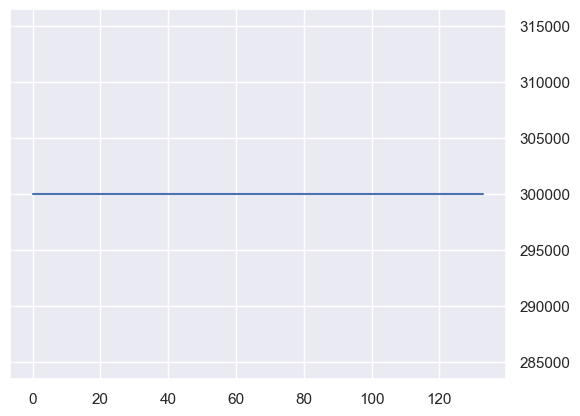

In [25]:
plt.plot(np.diff(df_eth["Time"].values[-135:]))

In [26]:
df_eth["date"].iloc[-135:].head(10)

45149    2023-06-06 19:50:00
45150    2023-06-06 19:55:00
45151    2023-06-06 20:00:00
45152    2023-06-06 20:05:00
45153    2023-06-06 20:10:00
45154    2023-06-06 20:15:00
45155    2023-06-06 20:20:00
45156    2023-06-06 20:25:00
45157    2023-06-06 20:30:00
45158    2023-06-06 20:35:00
Name: date, dtype: object

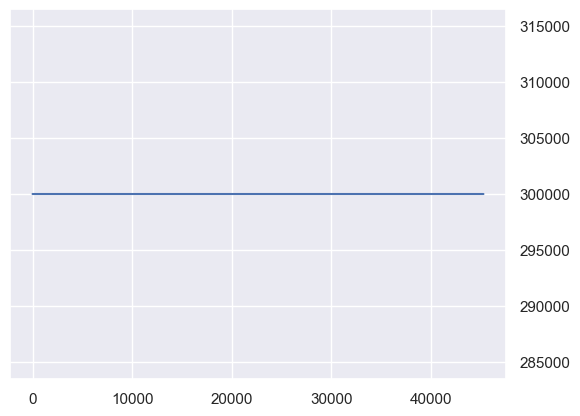

In [27]:
plt.plot(np.diff(df_eth_2["Time"].values))

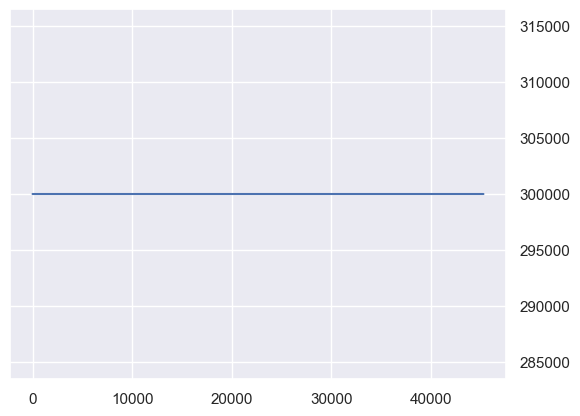

In [28]:
plt.plot(np.diff(df_eth_2["Time"].values))

In [29]:
test_time_continuity(df_eth)

Time gap!


False

In [30]:
test_time_continuity(df_eth_2)

True

In [31]:
def add_nb_time(df_in):
    """
    modify index to be the n-th time-step from first time.
    so a gap in time is reflected into index.
    add nb_time columns (maybe useless).
    """
    df = df_in.copy()
    delta_min = df["Time"].diff().value_counts().index[0]
    df["nb_time"] = ((df["Time"] - df["Time"].values[0]) / delta_min).astype(np.int64)
    df.index = df["nb_time"].values

    list_index = (
        list(set(list(range(df["nb_time"].values[-1]))) 
             - set(list(df["nb_time"].values)))
    )


    return df, list_index

In [32]:
def fill_time_gap(df_in, df_2):
    """
    Binance have some time gap into 1h data, so we have to merge with another 
    exchange data source (kucoin)
    So we use all prices of kucoin for missing dates
    Also, we add estimate unkonwn binance volumes in proportion of previous 
    "hour" known volumes from the two exchanges.

    """
    df = df_in.copy()
    if not test_time_continuity(df):
        if test_time_continuity(df_2):
            # modify index to be n-th time-step in absolute from first time
            df, list_index = add_nb_time(df)

            df_mix = df_2.copy()
            df_mix.loc[df.index] = df

            # correct volumes values : 
            # new vol_t =  vol_t(exchage 2) * vol_t-1(exch 1) / vol_t-1(exch 2)
            for index in list_index:
                print(f"Correcting volume index {index}")
                df_mix.at[index, "Volume"] = (
                    df_mix.at[index-1, "Volume"] 
                    / df_2.at[index-1, "Volume"]
                    * df_mix.at[index, "Volume"]
                )

            if not test_time_continuity(df_mix):
                raise Exception("Error no good mixed data")
            return df_mix
            
        else:
            raise Exception("Error good input data 2")
    else:
        return df

In [33]:
def fill_time_gap_interp(df_in, df_2):
    """
    Imputation of ohlcv CCTX nan data : 
    Binance have some time gap into 1h data, so we have to merge with another 
    exchange data source (kucoin) 
        So we use all prices of kucoin for missing dates
        Also, we add estimate unkonwn binance volumes in proportion of previous 
        "hour" known volumes from the two exchanges.

    If kucoin have also time gap ! OMG!
        So we use all prices of kucoin for missing dates
        If also Nan for kucoin, we interpolate (linear) binance data with Binance data only
        Nan & Zero volumes are interpolate also (unlike former fill_time_gap...) with Binance data only
    """
    df = df_in.copy()
    if not test_time_continuity(df):
        if test_time_continuity(df_2):
            # modify index to be n-th time-step in absolute from first time
            df, list_index = add_nb_time(df)

            df_mix = df_2.copy()
            df_mix.loc[df.index] = df

            # correct volumes values : 
            # new vol_t =  vol_t(exchage 2) * vol_t-1(exch 1) / vol_t-1(exch 2)
            for index in list_index:
                print(f"Correcting volume index {index}")
                df_mix.at[index, "Volume"] = (
                    df_mix.at[index-1, "Volume"] 
                    / df_2.at[index-1, "Volume"]
                    * df_mix.at[index, "Volume"]
                )

            if not test_time_continuity(df_mix):
                raise Exception("Error no good mixed data")
            return df_mix
            
        else:
            #raise Exception("Error good input data 2")

            # two exchanges have nan values !!! OMG!!!
            # use interpolate
            df, l_index = add_nb_time(df)
            df_2, l_index_2 = add_nb_time(df_2)
            new_index = np.array(range(max(df["nb_time"])+1))
            df = df.reindex(new_index)
            df_2 = df_2.reindex(new_index)
            df_mix = df.join(df_2, rsuffix='_2')
            b_nan = df_mix["Open"].isna()
            df_mix.loc[b_nan, "Open"] = df_mix.loc[b_nan, "Open_2"]
            df_mix.loc[b_nan, "High"] = df_mix.loc[b_nan, "High_2"]
            df_mix.loc[b_nan, "Low"] = df_mix.loc[b_nan, "Low_2"]
            df_mix.loc[b_nan, "Close"] = df_mix.loc[b_nan, "Close_2"]
            df_mix.loc[b_nan, "Time"] = df_mix.loc[b_nan, "Time_2"]
            df_mix.loc[b_nan, "date"] = df_mix.loc[b_nan, "date_2"]
            df_mix.loc[b_nan, "nb_time"] = df_mix.loc[b_nan, "nb_time_2"]

            # special volume zero :
            df_mix.loc[df_mix["Volume"] <= 0, "Volume"] = np.nan

            # interpolate 
            df_mix["Open"] = df_mix["Open"].interpolate()
            df_mix["High"] = df_mix["High"].interpolate()
            df_mix["Low"] = df_mix["Low"].interpolate()
            df_mix["Close"] = df_mix["Close"].interpolate()
            df_mix["Volume"] = df_mix["Volume"].interpolate()
            df_mix["Time"] = df_mix["Time"].interpolate()
            df_mix["nb_time"] = df_mix["nb_time"].interpolate()

            # Date
            df_mix['date'] = pd.to_datetime(df_mix['Time'], unit='ms') # -> date object
            df_mix['date'] = df_mix['date'].dt.strftime("%Y-%m-%d %H:%M:%S") # -> String

            # keep good col only
            # Time	Open	High	Low	Close	Volume	date	nb_time
            df_mix = df_mix[["Time",	"Open",	"High",	"Low",	
                            "Close",	"Volume",	"date",	"nb_time"]]
            
            if not test_time_continuity(df_mix):
                raise Exception("Error no good interpolated data")
            return df_mix

    else:
        return df

In [34]:
#df_eth = fill_time_gap(df_eth, df_eth_2)
#df_btc = fill_time_gap(df_btc, df_btc_2)
#df_bnb = fill_time_gap(df_bnb, df_bnb_2)

df_eth = fill_time_gap_interp(df_eth, df_eth_2)
df_btc = fill_time_gap_interp(df_btc, df_btc_2)
df_bnb = fill_time_gap_interp(df_bnb, df_bnb_2)

Time gap!
Correcting volume index 23776
Correcting volume index 23777
Correcting volume index 23778
Correcting volume index 23779
Correcting volume index 23780
Correcting volume index 23781
Correcting volume index 23782
Correcting volume index 23783
Correcting volume index 24016
Correcting volume index 23768
Correcting volume index 23769
Correcting volume index 23770
Correcting volume index 23771
Correcting volume index 23772
Correcting volume index 23773
Correcting volume index 23774
Correcting volume index 23775
Time gap!
Correcting volume index 23776
Correcting volume index 23777
Correcting volume index 23778
Correcting volume index 23779
Correcting volume index 23780
Correcting volume index 23781
Correcting volume index 23782
Correcting volume index 23783
Correcting volume index 24016
Correcting volume index 23768
Correcting volume index 23769
Correcting volume index 23770
Correcting volume index 23771
Correcting volume index 23772
Correcting volume index 23773
Correcting volume in

In [35]:
test_time_continuity(df_eth) and test_time_continuity(df_btc) and test_time_continuity(df_bnb) 

True

In [36]:
df_btc

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00
1,1672531500000,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00
2,1672531800000,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00
3,1672532100000,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00
4,1672532400000,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
45296,1686120000000,26818.31,26849.23,26817.42,26841.72,151.33117,2023-06-07 06:40:00
45297,1686120300000,26841.72,26882.35,26839.99,26840.00,163.21032,2023-06-07 06:45:00
45298,1686120600000,26840.00,26840.00,26818.98,26832.29,109.61746,2023-06-07 06:50:00
45299,1686120900000,26832.29,26851.80,26826.76,26829.30,81.69278,2023-06-07 06:55:00


Text(0.0, 1.0, 'Volume BTC binance')

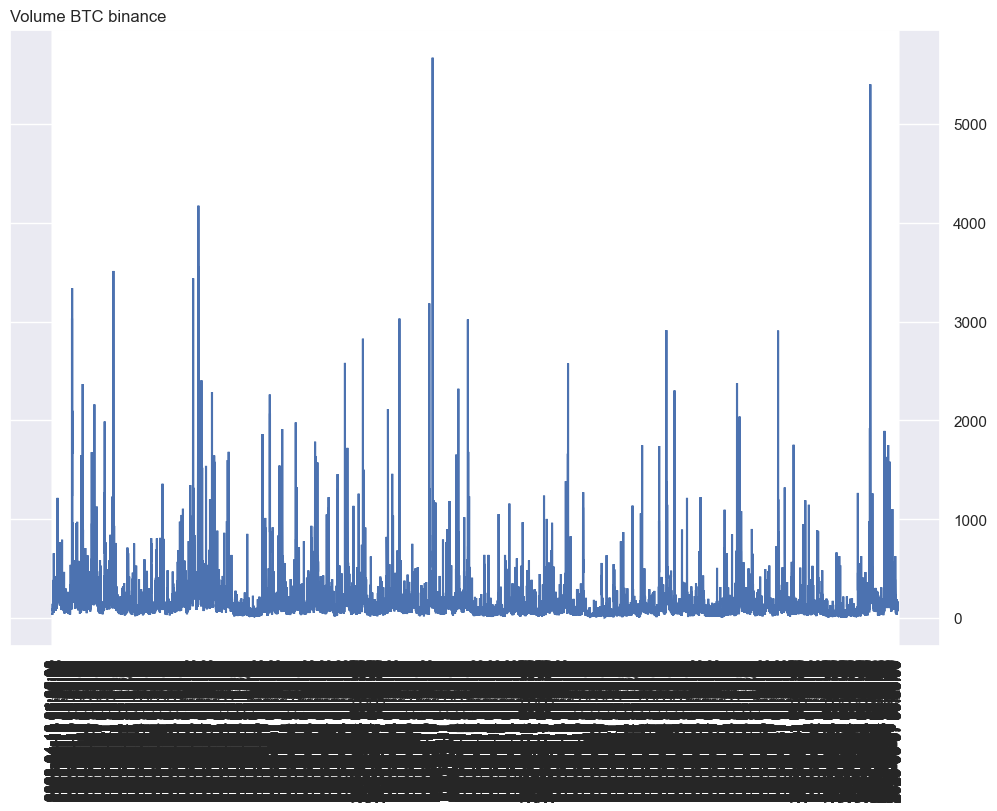

In [37]:
b_last = df_btc["date"] > "2023-04-18 04:00:00"
fig = plt.figure(figsize=(12, 8))
plt.plot(df_btc[b_last]["date"], df_btc[b_last]["Volume"])
plt.xticks(rotation=90)
plt.title("Volume BTC binance")

## Merge everything

In [38]:
def add_col_suffix(df_in, suffix):
    df = df_in.copy()
    dict_col = {}
    for col in df.columns:
        #print(col)
        if col != "Time":
            dict_col[col] = col + suffix
    #print(dict_col)
    #print(df)
    return df.rename(columns=dict_col)


In [39]:
# df_feat 
df_feat = df_eth.copy()
# merge BTC
df_feat = df_feat.merge(
    df_btc, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BTC")
)
# merge BNB
df_bnb_final = add_col_suffix(df_bnb, "_BNB")
df_feat = df_feat.merge(
    df_bnb_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BNB")
)

df_feat.shape

(45301, 19)

In [40]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,Open_BTC,High_BTC,Low_BTC,Close_BTC,Volume_BTC,date_BTC,Open_BNB,High_BNB,Low_BNB,Close_BNB,Volume_BNB,date_BNB
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00,246.3,246.4,245.9,246.2,440.108,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00,246.2,246.2,246.0,246.1,96.972,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00,246.1,246.1,246.0,246.0,242.254,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00,246.0,246.2,245.8,246.2,369.308,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00,246.2,246.5,246.1,246.4,149.299,2023-01-01 00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45296,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00,26818.31,26849.23,26817.42,26841.72,151.33117,2023-06-07 06:40:00,278.0,278.3,277.9,278.1,1242.310,2023-06-07 06:40:00
45297,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00,26841.72,26882.35,26839.99,26840.00,163.21032,2023-06-07 06:45:00,278.1,278.5,277.9,278.0,1334.771,2023-06-07 06:45:00
45298,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00,26840.00,26840.00,26818.98,26832.29,109.61746,2023-06-07 06:50:00,277.9,278.1,277.7,278.0,1788.287,2023-06-07 06:50:00
45299,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00,26832.29,26851.80,26826.76,26829.30,81.69278,2023-06-07 06:55:00,278.1,278.2,277.7,277.8,611.021,2023-06-07 06:55:00


## Save

In [41]:
path_save_df_feat

'data/df_feat_05m.csv'

In [42]:
df_feat.to_csv(path_save_df_feat, index=False)

## Add price action indicators

Ichimoku 1h 1D 1W

In [43]:
def add_ichimoku(df):
    """
    Create & add ichimoku data at different ranges : 1h 1D 1W
    Take timestep 1h data as input only

    Ex: df_out = add_ichimoku(df_in)
    
    """

    df_out = df.copy()

    indic_ichi = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True
    )
    df_out["ichi_cloud_a"] = indic_ichi.ichimoku_a()
    df_out["ichi_cloud_b"] = indic_ichi.ichimoku_b()
    df_out["ichi_kijun"] = indic_ichi.ichimoku_base_line()
    df_out["ichi_tenkan"] = indic_ichi.ichimoku_conversion_line()

    indic_ichi_day = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24,
        window2=26*24,
        window3=52*24,
    )
    df_out["ichi_cloud_a_day"] = indic_ichi_day.ichimoku_a()
    df_out["ichi_cloud_b_day"] = indic_ichi_day.ichimoku_b()
    df_out["ichi_kijun_day"] = indic_ichi_day.ichimoku_base_line()
    df_out["ichi_tenkan_day"] = indic_ichi_day.ichimoku_conversion_line()

    indic_ichi_week = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24*7,
        window2=26*24*7,
        window3=52*24*7,
    )
    df_out["ichi_cloud_a_week"] = indic_ichi_week.ichimoku_a()
    df_out["ichi_cloud_a_week"].ffill(inplace=True)
    df_out["ichi_cloud_b_week"] = indic_ichi_week.ichimoku_b()
    df_out["ichi_kijun_week"] = indic_ichi_week.ichimoku_base_line()
    df_out["ichi_tenkan_week"] = indic_ichi_week.ichimoku_conversion_line()
    
    return df_out

df_eth = add_ichimoku(df_eth)
df_btc = add_ichimoku(df_btc)

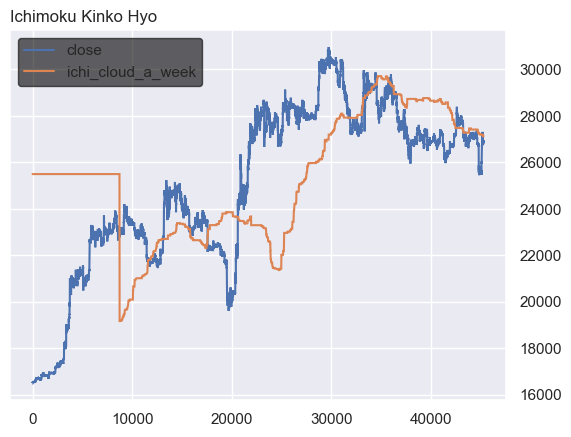

In [44]:
plt.plot(df_btc.Close, label="close")
plt.plot(df_btc["ichi_cloud_a_week"], label='ichi_cloud_a_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

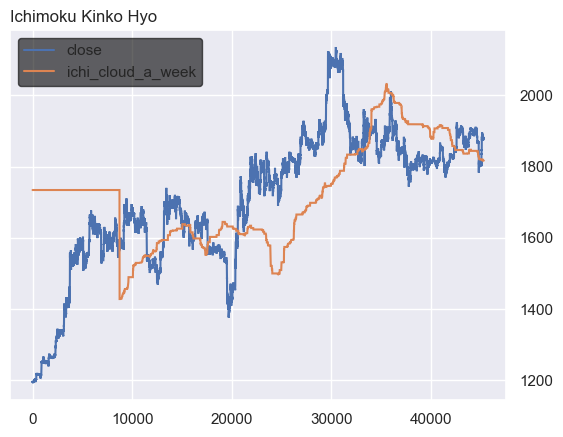

In [45]:
plt.plot(df_eth.Close, label="close")
plt.plot(df_eth["ichi_cloud_a_week"], label='ichi_cloud_a_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

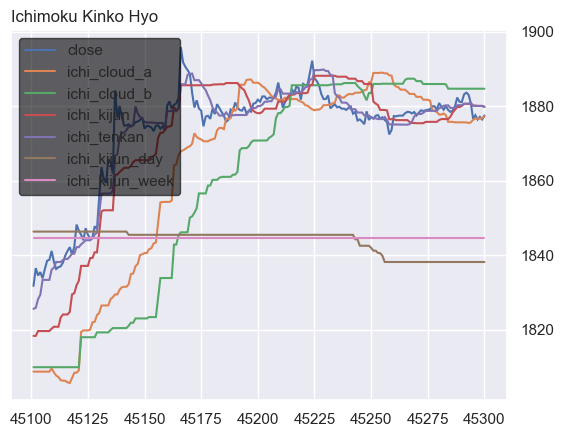

In [46]:
plt.plot(df_eth[-200:].Close, label="close")
plt.plot(df_eth[-200:]["ichi_cloud_a"], label='ichi_cloud_a')
plt.plot(df_eth[-200:]["ichi_cloud_b"], label='ichi_cloud_b')
plt.plot(df_eth[-200:]["ichi_kijun"], label='ichi_kijun')
plt.plot(df_eth[-200:]["ichi_tenkan"], label='ichi_tenkan')
plt.plot(df_eth[-200:]["ichi_kijun_day"], label='ichi_kijun_day')
plt.plot(df_eth[-200:]["ichi_kijun_week"], label='ichi_kijun_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

RSI 14  1h 1D 1W

In [47]:

# RSIIndicator(close: pandas.core.series.Series, window: int = 14, fillna: bool = False)
def add_rsi(df, n=14):
    df_out = df.copy()
    df_out["rsi_h"] = RSIIndicator(df["High"], window=n).rsi()
    df_out["rsi_d"] = RSIIndicator(df["High"], window=n*24).rsi()
    df_out["rsi_w"] = RSIIndicator(df["High"], window=n*24*7).rsi()
    return df_out


df_eth = add_rsi(df_eth)
df_btc = add_rsi(df_btc)
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,ichi_cloud_b_day,ichi_kijun_day,ichi_tenkan_day,ichi_cloud_a_week,ichi_cloud_b_week,ichi_kijun_week,ichi_tenkan_week,rsi_h,rsi_d,rsi_w
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1709.609364,1708.873167,NaN,...,1700.824226,NaN,NaN,1734.220468,1654.813232,NaN,NaN,NaN,NaN,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1709.609364,1708.873167,NaN,...,1700.824226,NaN,NaN,1734.220468,1654.813232,NaN,NaN,NaN,NaN,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1709.609364,1708.873167,NaN,...,1700.824226,NaN,NaN,1734.220468,1654.813232,NaN,NaN,NaN,NaN,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1709.609364,1708.873167,NaN,...,1700.824226,NaN,NaN,1734.220468,1654.813232,NaN,NaN,NaN,NaN,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1709.609364,1708.873167,NaN,...,1700.824226,NaN,NaN,1734.220468,1654.813232,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45296,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00,1876.665000,1884.695000,1880.130,...,1877.315000,1838.145,1848.095,1816.720000,1879.500000,1844.515,1846.315,38.857630,52.185843,50.343017
45297,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00,1876.665000,1884.695000,1880.075,...,1877.315000,1838.145,1848.095,1816.720000,1879.500000,1844.515,1846.315,45.079751,52.349129,50.371707
45298,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00,1876.665000,1884.695000,1880.070,...,1877.315000,1838.145,1848.095,1816.720000,1879.500000,1844.515,1846.315,38.379065,52.065026,50.325365
45299,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00,1876.807500,1884.695000,1880.070,...,1877.315000,1838.145,1848.095,1817.352500,1879.500000,1844.515,1846.315,41.577362,52.154094,50.340996


Choppiness Index = 100 * LOG10(SUM(ATR(1),n) / (MaxHi(n) – MinLo(n))) / LOG10(n), where:  

  – n is the user-defined period length  
  – ATR(1) is the Average True Range (Period of 1)  
  – SUM(ATR(1), n) is the sum of the Average True Range over past n periods  
  – MaxHi(n) is the the highest high over the past n periods  
  – MinLo(n) is the lowest low over the past n periods  

In [48]:
# add CHOP indicator on 1hour 1day 1week 
def add_chop(df, n):
    df_out = df.copy()

    def calculate_chop(df, n, k):
        #(high: pandas.core.series.Series, 
        # low: pandas.core.series.Series, 
        # close: pandas.core.series.Series, 
        # window: int = 14, 
        # fillna: bool = False)
        atr = AverageTrueRange(
            high=df["High"],
            low=df["Low"],
            close=df["Close"],
            window=1*k,
            ).average_true_range()
        sum_atr = atr.rolling(n*k).sum()
        max_high = df_out["High"].rolling(n*k).max()
        min_low = df_out["Low"].rolling(n*k).min()
        chop = 100 * np.log10(sum_atr / (max_high - min_low )) / np.log10(n*k)
        return chop, atr, max_high, min_low
    
    
    def  add_chop_col(df_out, n, k):
        chop, atr, max_high, min_low = calculate_chop(df_out, n, k)
        if k == 1:
            df_out["max_high_h"] = max_high
            df_out["min_low_h"] = min_low
            df_out["atr_h"] = atr
            df_out["chop_h"] = chop
        elif (k==24):
            df_out["max_high_d"] = max_high
            df_out["min_low_d"] = min_low
            df_out["atr_d"] = atr
            df_out["chop_d"] = chop   
        elif (k==24*7):
            df_out["max_high_w"] = max_high
            df_out["min_low_w"] = min_low
            df_out["atr_w"] = atr
            df_out["chop_w"] = chop  
        else:
            df_out[f"max_high_{k}"] = max_high
            df_out[f"min_low_{k}"] = min_low
            df_out[f"atr_{k}"] = atr
            df_out[f"chop_{k}"] = chop
        return df_out                       
    # 1h
    df_out = add_chop_col(df_out, n, 1)
    # 1day
    df_out = add_chop_col(df_out, n, 24)    
    # 1week
    df_out = add_chop_col(df_out, n, 24*7)

    return df_out

df_eth = add_chop(df_eth, 14)
df_btc = add_chop(df_btc, 14)
df_eth[["date", "High", "Low", "Close", 
         "atr_h", "max_high_h","min_low_h", "chop_h",
         "atr_d", "max_high_d","min_low_d", "chop_d",
         "atr_w", "max_high_w","min_low_w", "chop_w"]].tail(30)


,date,High,Low,Close,atr_h,max_high_h,min_low_h,chop_h,atr_d,max_high_d,min_low_d,chop_d,atr_w,max_high_w,min_low_w,chop_w
45271,2023-06-07 04:35:00,1878.83,1877.50,1878.20,1.33,1879.27,1871.59,44.126867,2.055428,1898.29,1797.18,38.607031,2.970234,1917.0,1778.0,46.429540
45272,2023-06-07 04:40:00,1879.00,1878.06,1878.89,0.94,1879.27,1871.59,38.385690,2.008952,1898.29,1797.18,38.603658,2.958149,1917.0,1778.0,46.430966
45273,2023-06-07 04:45:00,1879.20,1877.92,1878.72,1.28,1879.27,1872.87,43.739970,1.978579,1898.29,1797.18,38.599960,2.948160,1917.0,1778.0,46.432312
45274,2023-06-07 04:50:00,1879.95,1878.72,1878.90,1.23,1879.95,1875.12,47.771492,1.947388,1898.29,1797.18,38.595906,2.937933,1917.0,1778.0,46.433617
45275,2023-06-07 04:55:00,1880.00,1878.89,1879.04,1.11,1880.00,1876.53,56.492219,1.912497,1898.29,1797.18,38.591464,2.927053,1917.0,1778.0,46.434883
45276,2023-06-07 05:00:00,1879.37,1879.03,1879.19,0.34,1880.00,1876.53,53.233139,1.846976,1898.29,1797.18,38.586680,2.911654,1917.0,1778.0,46.436075
45277,2023-06-07 05:05:00,1880.00,1879.18,1879.99,0.82,1880.00,1876.53,51.196315,1.804185,1898.29,1797.18,38.581006,2.899203,1917.0,1778.0,46.437236
45278,2023-06-07 05:10:00,1880.00,1879.03,1879.97,0.97,1880.00,1877.10,57.683519,1.769428,1898.29,1797.18,38.575244,2.887720,1917.0,1778.0,46.438348
45279,2023-06-07 05:15:00,1880.00,1878.98,1878.99,1.02,1880.00,1877.50,63.307497,1.738202,1898.29,1797.18,38.569209,2.876603,1917.0,1778.0,46.439452
45280,2023-06-07 05:20:00,1880.95,1878.98,1880.86,1.97,1880.95,1877.50,54.768923,1.747860,1898.29,1797.18,38.564175,2.871206,1917.0,1778.0,46.440552


VWAP (Volume-Weighted Average Price ) at 
- several period
  - 1 day
  - 1 week
  - 1 month
  - 3 months
  - 6 months
  - 12 months  
   
  
https://school.stockcharts.com/doku.php?id=technical_indicators:vwap_intraday  

- VWAP = Cumulative(Volume x Typical Price)/Cumulative(Volume) on a time period
  - Typical Price = (High+Low+Close)/3
  - Trying to have an indicator to estimate Volume profile?

- Close to Realized Price (https://www.decentrader.com/charts/mvrv/) : 
  - MVRV = Market Value / Realized Value
  - Market Value = Price x number of coins in circulation
  - Realized Value = Cost basis of all available bitcoins in the market.
  - MVRV can be approximate with = VWAP / Typical Price

In [49]:
# VWAP 1D 1W 1M 3M 6M 1Y for ETH and BTC
# VolumeWeightedAveragePrice(high: pandas.core.series.Series,
# low: pandas.core.series.Series, 
# close: pandas.core.series.Series, 
# volume: pandas.core.series.Series, 
# window: int = 14, 
# fillna: bool = False)
# volume_weighted_average_price
def add_vwap(df, n=1):
    df_out = df.copy()
    # 1hour
    df_out["vwap_h"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=14,
        fillna=True,
        ).volume_weighted_average_price()
    # 1day
    df_out["vwap_d"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24).volume_weighted_average_price()    
    # 1week
    df_out["vwap_w"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7).volume_weighted_average_price() 
    # 1month
    df_out["vwap_m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30).volume_weighted_average_price() 
    # 3months
    df_out["vwap_3m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30*3).volume_weighted_average_price() 
    # 6months
    df_out["vwap_6m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30*6).volume_weighted_average_price() 
    # 1year
    df_out["vwap_y"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=n*24*365,
        fillna=True,
        ).volume_weighted_average_price()
    # all time
    df_out["vwap_all"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=df_out.shape[0],
        fillna=True,
        ).volume_weighted_average_price()
    return df_out


df_eth = add_vwap(df_eth)
df_btc = add_vwap(df_btc)
df_eth


,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,atr_w,chop_w,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1709.609364,1708.873167,NaN,...,0.000000,NaN,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1709.609364,1708.873167,NaN,...,0.000000,NaN,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1709.609364,1708.873167,NaN,...,0.000000,NaN,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1709.609364,1708.873167,NaN,...,0.000000,NaN,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1709.609364,1708.873167,NaN,...,0.000000,NaN,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45296,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00,1876.665000,1884.695000,1880.130,...,2.778436,46.458002,1880.869558,1880.457670,1879.053810,1850.601424,1879.702507,1781.109096,1836.250433,1705.500066
45297,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00,1876.665000,1884.695000,1880.075,...,2.780112,46.459126,1880.726824,1880.361447,1879.147804,1850.608746,1879.697064,1781.115396,1836.249881,1705.502054
45298,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00,1876.665000,1884.695000,1880.070,...,2.768088,46.460242,1880.610939,1880.306931,1879.926345,1850.615265,1879.692915,1781.119323,1836.248184,1705.503346
45299,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00,1876.807500,1884.695000,1880.070,...,2.760480,46.461360,1880.440724,1880.179156,1880.484743,1850.624203,1879.690913,1781.128991,1836.248047,1705.505684


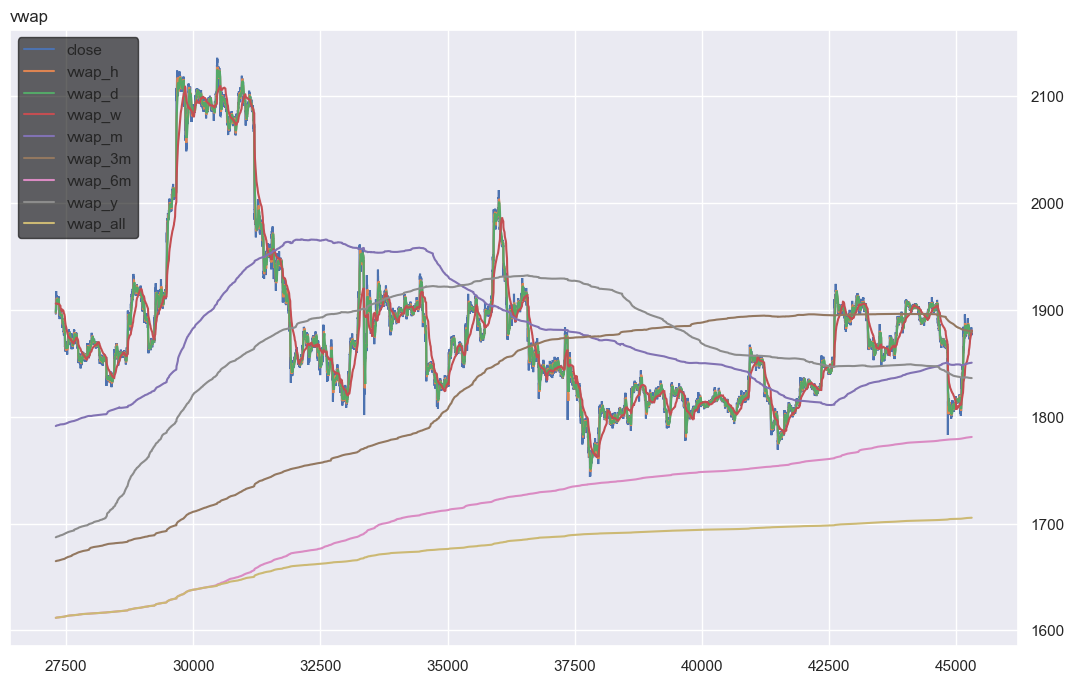

In [50]:
nb_point = 18000
fig = plt.figure()
fig.set_size_inches([13,8])
plt.plot(df_eth[-nb_point:].Close, label="close")
plt.plot(df_eth[-nb_point:]["vwap_h"], label='vwap_h')
plt.plot(df_eth[-nb_point:]["vwap_d"], label='vwap_d')
plt.plot(df_eth[-nb_point:]["vwap_w"], label='vwap_w')
plt.plot(df_eth[-nb_point:]["vwap_m"], label='vwap_m')
plt.plot(df_eth[-nb_point:]["vwap_3m"], label='vwap_3m')
plt.plot(df_eth[-nb_point:]["vwap_6m"], label='vwap_6m')
plt.plot(df_eth[-nb_point:]["vwap_y"], label='vwap_y')
plt.plot(df_eth[-nb_point:]["vwap_all"], label='vwap_all')
plt.title('vwap')
plt.legend()
plt.show()

- MVRV Z-Score
  - (Market Value - Realized Value) / Std(Market Value)
    - approxamte with  : on 1 period: (Typical Price - VWAP) / Std(Typical Price)

In [51]:
# MVRV Z-score : (Market Value - Realized Value) / Std(Market Value)
# approximated by : (Close - VWAP(all time) ) / Std(Close from first date)
# nb_max_period = df_eth.shape[0]

df_eth["vwap_z_score"] = (df_eth["Close"] - df_eth["vwap_all"]) / df_eth["Close"].expanding(1).std()
df_btc["vwap_z_score"] = (df_btc["Close"] - df_btc["vwap_all"]) / df_btc["Close"].expanding(1).std()
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,chop_w,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1709.609364,1708.873167,NaN,...,NaN,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1709.609364,1708.873167,NaN,...,NaN,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1709.609364,1708.873167,NaN,...,NaN,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1709.609364,1708.873167,NaN,...,NaN,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1709.609364,1708.873167,NaN,...,NaN,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45296,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00,1876.665000,1884.695000,1880.130,...,46.458002,1880.869558,1880.457670,1879.053810,1850.601424,1879.702507,1781.109096,1836.250433,1705.500066,0.896044
45297,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00,1876.665000,1884.695000,1880.075,...,46.459126,1880.726824,1880.361447,1879.147804,1850.608746,1879.697064,1781.115396,1836.249881,1705.502054,0.889995
45298,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00,1876.665000,1884.695000,1880.070,...,46.460242,1880.610939,1880.306931,1879.926345,1850.615265,1879.692915,1781.119323,1836.248184,1705.503346,0.893792
45299,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00,1876.807500,1884.695000,1880.070,...,46.461360,1880.440724,1880.179156,1880.484743,1850.624203,1879.690913,1781.128991,1836.248047,1705.505684,0.890189


NUPL : Net Unrealized Profit/Loss
- NUPL = (Market Value - Realized Value) / Market Value
- https://academy.glassnode.com/indicators/profit-loss-unrealized/net-unrealized-profit-loss
- https://www.lookintobitcoin.com/charts/relative-unrealized-profit--loss/

- Approximated with :  = (Typical Price - VWAP) / Typical Price on all times



In [52]:
# NUPL 
df_eth["nupl"] = (df_eth["Close"] - df_eth["vwap_all"]) / df_eth["Close"]
df_btc["nupl"] = (df_btc["Close"] - df_btc["vwap_all"]) / df_btc["Close"]
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1709.609364,1708.873167,NaN,...,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN,0.000187
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1709.609364,1708.873167,NaN,...,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1709.609364,1708.873167,NaN,...,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1709.609364,1708.873167,NaN,...,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593,0.000338
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1709.609364,1708.873167,NaN,...,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856,0.000371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45296,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00,1876.665000,1884.695000,1880.130,...,1880.869558,1880.457670,1879.053810,1850.601424,1879.702507,1781.109096,1836.250433,1705.500066,0.896044,0.091645
45297,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00,1876.665000,1884.695000,1880.075,...,1880.726824,1880.361447,1879.147804,1850.608746,1879.697064,1781.115396,1836.249881,1705.502054,0.889995,0.091082
45298,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00,1876.665000,1884.695000,1880.070,...,1880.610939,1880.306931,1879.926345,1850.615265,1879.692915,1781.119323,1836.248184,1705.503346,0.893792,0.091435
45299,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00,1876.807500,1884.695000,1880.070,...,1880.440724,1880.179156,1880.484743,1850.624203,1879.690913,1781.128991,1836.248047,1705.505684,0.890189,0.091100


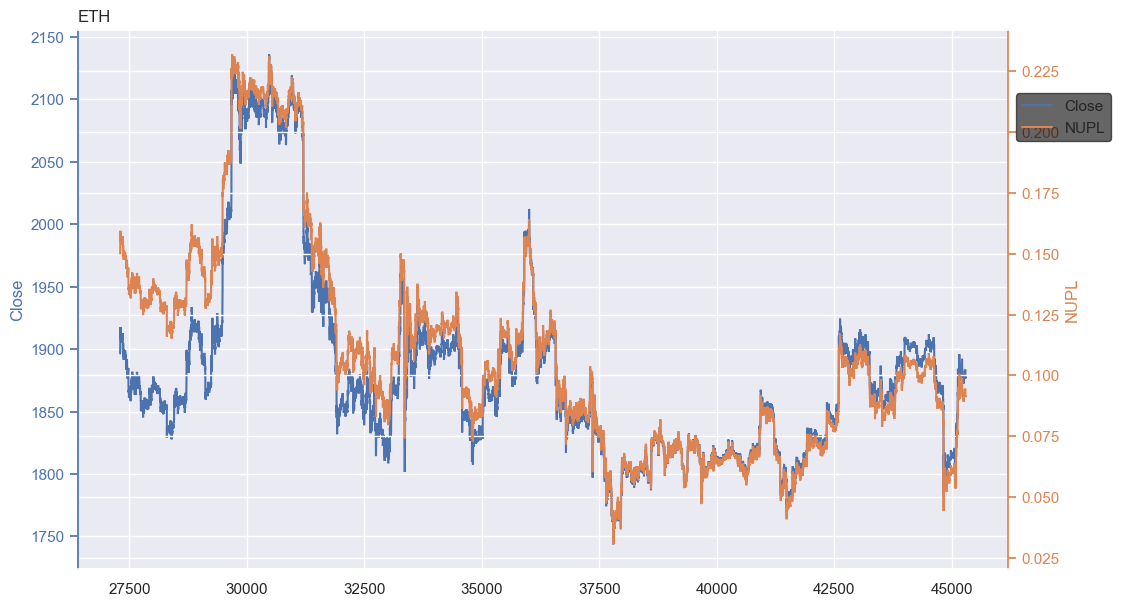

In [53]:
nb_point = 18000



fig, ax1 = plt.subplots()
fig.set_size_inches([12,7])
ax1.plot(df_eth[-nb_point:].Close)
ax1.set_ylabel('Close', color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')

ax1.set_title('ETH')

ax2 = ax1.twinx()
ax2.plot(df_eth[-nb_point:]["nupl"],'C1')
ax2.set_ylabel('NUPL', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

fig.legend(['Close','NUPL'], bbox_to_anchor=(0.9, 0.8))

plt.show()

## Crypto Fear & Greed Index
- https://alternative.me/crypto/fear-and-greed-index/

In [54]:
# https://api.alternative.me/fng/?limit=370&format=csv
nb_days = int(np.ceil(df_eth.shape[0]/24))
response = requests.get(f"https://api.alternative.me/fng/?limit={nb_days}")

d_fear = json.loads(response.text)
nb_days = len(d_fear["data"])
df_fear = pd.DataFrame(
    [int(d_fear["data"][i_time]["timestamp"])*1000 
     for i_time in range(nb_days) ], columns=["Time"])
df_fear["fear_greed"] = [
    int(d_fear["data"][i_time]["value"]) 
    for i_time in range(nb_days)]
df_fear["fear_greed_class"] = [
    d_fear["data"][i_time]["value_classification"]
    for i_time in range(nb_days)]

df_eth = df_eth.merge(df_fear, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
df_eth["fear_greed"] = df_eth["fear_greed"].ffill()
df_eth["fear_greed_class"] = df_eth["fear_greed_class"].ffill()
df_eth.loc[df_eth["fear_greed"].isna(), "fear_greed"] = 50
df_eth.loc[df_eth["fear_greed_class"].isna(), "fear_greed_class"] = "Neutral"
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1709.609364,1708.873167,NaN,...,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN,0.000187,26.0,Fear
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1709.609364,1708.873167,NaN,...,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353,26.0,Fear
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1709.609364,1708.873167,NaN,...,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920,26.0,Fear
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1709.609364,1708.873167,NaN,...,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593,0.000338,26.0,Fear
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1709.609364,1708.873167,NaN,...,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856,0.000371,26.0,Fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45296,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00,1876.665000,1884.695000,1880.130,...,1879.053810,1850.601424,1879.702507,1781.109096,1836.250433,1705.500066,0.896044,0.091645,53.0,Neutral
45297,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00,1876.665000,1884.695000,1880.075,...,1879.147804,1850.608746,1879.697064,1781.115396,1836.249881,1705.502054,0.889995,0.091082,53.0,Neutral
45298,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00,1876.665000,1884.695000,1880.070,...,1879.926345,1850.615265,1879.692915,1781.119323,1836.248184,1705.503346,0.893792,0.091435,53.0,Neutral
45299,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00,1876.807500,1884.695000,1880.070,...,1880.484743,1850.624203,1879.690913,1781.128991,1836.248047,1705.505684,0.890189,0.091100,53.0,Neutral


In [55]:
df_eth.head(25)

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1709.609364,1708.873167,NaN,...,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN,0.000187,26.0,Fear
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1709.609364,1708.873167,NaN,...,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353,26.0,Fear
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1709.609364,1708.873167,NaN,...,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920,26.0,Fear
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1709.609364,1708.873167,NaN,...,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593,0.000338,26.0,Fear
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1709.609364,1708.873167,NaN,...,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856,0.000371,26.0,Fear
5,1672532700000,1196.06,1196.70,1196.06,1196.61,394.9124,2023-01-01 00:25:00,1709.609364,1708.873167,NaN,...,1195.754893,1195.754893,1195.754893,1195.754893,1195.754893,1195.754893,1.150158,0.000715,26.0,Fear
6,1672533000000,1196.62,1196.62,1193.72,1194.36,497.8406,2023-01-01 00:30:00,1709.609364,1708.873167,NaN,...,1195.607388,1195.607388,1195.607388,1195.607388,1195.607388,1195.607388,-1.427337,-0.001044,26.0,Fear
7,1672533300000,1194.37,1194.43,1192.72,1194.22,1299.5971,2023-01-01 00:35:00,1709.609364,1708.873167,NaN,...,1195.043013,1195.043013,1195.043013,1195.043013,1195.043013,1195.043013,-0.869632,-0.000689,26.0,Fear
8,1672533600000,1194.22,1194.22,1193.02,1193.64,409.5032,2023-01-01 00:40:00,1709.609364,1708.873167,NaN,...,1194.916773,1194.916773,1194.916773,1194.916773,1194.916773,1194.916773,-1.194916,-0.001070,26.0,Fear
9,1672533900000,1193.64,1195.06,1193.63,1194.64,521.0221,2023-01-01 00:45:00,1709.609364,1708.873167,NaN,...,1194.868552,1194.868552,1194.868552,1194.868552,1194.868552,1194.868552,-0.223011,-0.000191,26.0,Fear


In [56]:
df_eth.tail(25)

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
45276,1686114000000,1879.03,1879.37,1879.03,1879.19,276.4246,2023-06-07 05:00:00,1881.4850,1885.955,1875.795,...,1874.231926,1850.384198,1879.928999,1781.013357,1836.302222,1705.460129,0.904646,0.092449,53.0,Neutral
45277,1686114300000,1879.19,1880.00,1879.18,1879.99,323.2473,2023-06-07 05:05:00,1878.9800,1885.955,1875.795,...,1874.522743,1850.387510,1879.914215,1781.016338,1836.281520,1705.460874,0.908810,0.092835,53.0,Neutral
45278,1686114600000,1879.99,1880.00,1879.03,1879.97,866.5489,2023-06-07 05:10:00,1878.7275,1885.955,1875.795,...,1874.798260,1850.394757,1879.904859,1781.020734,1836.273850,1705.462868,0.908697,0.092824,53.0,Neutral
45279,1686114900000,1879.97,1880.00,1878.98,1878.99,806.2911,2023-06-07 05:15:00,1878.4250,1885.955,1875.795,...,1875.167044,1850.402618,1879.898032,1781.026096,1836.264987,1705.464721,0.903587,0.092350,53.0,Neutral
45280,1686115200000,1878.99,1880.95,1878.98,1880.86,804.8622,2023-06-07 05:20:00,1877.7700,1885.955,1876.270,...,1875.391677,1850.409443,1879.873237,1781.031930,1836.265223,1705.466580,0.913317,0.093252,53.0,Neutral
45281,1686115500000,1880.86,1881.50,1879.78,1879.87,723.1461,2023-06-07 05:25:00,1877.7650,1885.955,1876.545,...,1875.533849,1850.415521,1879.865759,1781.036351,1836.264743,1705.468251,0.908155,0.092773,53.0,Neutral
45282,1686115800000,1879.86,1880.02,1879.07,1879.07,339.1924,2023-06-07 05:30:00,1878.0300,1885.955,1876.545,...,1875.719948,1850.420486,1879.843057,1781.042027,1836.262111,1705.469030,0.903987,0.092387,53.0,Neutral
45283,1686116100000,1879.07,1880.82,1879.07,1880.00,1290.8398,2023-06-07 05:35:00,1877.5850,1885.875,1876.545,...,1875.835255,1850.432985,1879.802776,1781.047536,1836.262405,1705.472006,0.908817,0.092834,53.0,Neutral
45284,1686116400000,1880.00,1880.00,1878.99,1878.99,483.8858,2023-06-07 05:40:00,1875.8075,1884.710,1876.545,...,1875.980250,1850.447449,1879.796748,1781.050422,1836.260878,1705.473118,0.903554,0.092346,53.0,Neutral
45285,1686116700000,1879.00,1879.24,1877.56,1878.47,689.0150,2023-06-07 05:45:00,1875.7925,1884.695,1877.185,...,1876.200927,1850.479225,1879.781490,1781.054385,1836.257253,1705.474692,0.900840,0.092094,53.0,Neutral


## Daily economic infos 
- LTH-MVRV ? equiv to Price / VWAP 6 months ago : NOK
- STH-MVRV ? equiv to Price / VWAP of the last 6 months : NOK
- Dave’s Logarithmic Growth Curve ? : NOK

Others tickers:

- US02Y no but US05Y from yahoo finance
- ETHBTC : to be calculated
- SP500
- DXY

TODO ? 
- open interest 
- NASDAC


US02Y : 

In [57]:
datetime.strptime(FIRST_DATE, "%Y-%m-%d %H:%M:%S")

datetime.datetime(2023, 1, 1, 0, 0)

openbb  for index is not good about datetime and DXY no data

In [58]:
openbb.economy.available_indices()

{'sp500': {'name': 'S&P 500 Index', 'ticker': '^GSPC'},
 'sp400': {'name': 'S&P 400 Mid Cap Index', 'ticker': '^SP400'},
 'sp600': {'name': 'S&P 600 Small Cap Index', 'ticker': '^SP600'},
 'sp500tr': {'name': 'S&P 500 TR Index', 'ticker': '^SP500TR'},
 'sp_xsp': {'name': 'S&P 500 Mini SPX Options Index', 'ticker': '^XSP'},
 'nyse_ny': {'name': 'NYSE US 100 Index', 'ticker': '^NY'},
 'dow_djus': {'name': 'Dow Jones US Index', 'ticker': '^DJUS'},
 'nyse': {'name': 'NYSE Composite Index', 'ticker': '^NYA'},
 'amex': {'name': 'NYSE-AMEX Composite Index', 'ticker': '^XAX'},
 'nasdaq': {'name': 'Nasdaq Composite Index', 'ticker': '^IXIC'},
 'nasdaq100': {'name': 'NASDAQ 100', 'ticker': '^NDX'},
 'nasdaq100_ew': {'name': 'NASDAQ 100 Equal Weighted Index',
  'ticker': '^NDXE'},
 'nasdaq50': {'name': 'NASDAQ Q50 Index', 'ticker': '^NXTQ'},
 'russell1000': {'name': 'Russell 1000 Index', 'ticker': '^RUI'},
 'russell2000': {'name': 'Russell 2000 Index', 'ticker': '^RUT'},
 'cboe_bxr': {'name': 'CB

In [59]:
openbb.economy.treasury(instruments=["nominal"], maturities=["2y"], frequency="daily", start_date="2023-01-01")

,Nominal_2-year
TIME_PERIOD,
2023-01-03,4.40
2023-01-04,4.36
2023-01-05,4.45
2023-01-06,4.24
2023-01-09,4.19
...,...
2023-05-26,4.54
2023-05-30,4.46
2023-05-31,4.40


In [60]:
def req_yf_date(ticker):
    data = yf.Ticker(ticker).history(interval="1h", period="2y")
    # date
    data["date"] = pd.to_datetime(data.index, utc=True)
    data["date"] = data["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    data["Time"] = data["date"].apply(exchange.parse8601)
    data["date"] = pd.to_datetime(data["date"],  utc=True)
    data["date"] = data["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    data = data.reset_index()
    print("First date: ", data["Datetime"].values[0])
    print("Last date: ", data["Datetime"].values[-1])
    # data = data[["Time", "date", "Close"]]
    return data

def add_ticker_data(symbol, path_data):
    """
    Merge new data
    not optimized : download all new data and merge
    """
    df_new = req_yf_date(symbol)
    if os.path.isfile(path_data):
        df = pd.read_csv(path_data)
        list_col = df.columns
        if df["Time"].values[-1] < df_new["Time"].values[-1]:
            print("New data available...")
            df = df.merge(df_new, 
                left_on='Time', 
                right_on='Time', 
                how="outer",
                suffixes=("", "_new")
            )
            for col in list_col:
                if col != 'Time':
                    df.loc[df[col].isna(), col] = df.loc[df[col].isna(), f"{col}_new"]

            df = df[list_col]
            df.to_csv(path_data, index=False)

        return df
    else:
        df_new.to_csv(path_data, index=False)
        return df_new

U.S. Treasury Yield 5 Years

In [61]:
#df_fvx = yf.Ticker("^FVX").history(interval="1h", period="2y")
path_fvx = os.path.join(PATH_DATA, "df_fvx.csv")
df_fvx = add_ticker_data("^FVX", path_fvx)
df_fvx

First date:  2021-06-07T12:00:00.000000000
Last date:  2023-06-06T18:00:00.000000000


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 08:00:00-05:00,0.514,0.524,0.514,0.521,0.0,0.0,0.0,2021-02-16 13:00:00,1613480400000
1,2021-02-16 09:00:00-05:00,0.521,0.527,0.516,0.527,0.0,0.0,0.0,2021-02-16 14:00:00,1613484000000
2,2021-02-16 10:00:00-05:00,0.529,0.532,0.522,0.529,0.0,0.0,0.0,2021-02-16 15:00:00,1613487600000
3,2021-02-16 11:00:00-05:00,0.529,0.553,0.529,0.551,0.0,0.0,0.0,2021-02-16 16:00:00,1613491200000
4,2021-02-16 12:00:00-05:00,0.551,0.553,0.545,0.546,0.0,0.0,0.0,2021-02-16 17:00:00,1613494800000
...,...,...,...,...,...,...,...,...,...,...
4053,2023-06-06 10:00:00-04:00,3.839,3.882,3.835,3.861,0.0,0.0,0.0,2023-06-06 14:00:00,1686060000000
4054,2023-06-06 11:00:00-04:00,3.861,3.875,3.847,3.854,0.0,0.0,0.0,2023-06-06 15:00:00,1686063600000
4055,2023-06-06 12:00:00-04:00,3.854,3.867,3.851,3.858,0.0,0.0,0.0,2023-06-06 16:00:00,1686067200000
4056,2023-06-06 13:00:00-04:00,3.856,3.863,3.851,3.860,0.0,0.0,0.0,2023-06-06 17:00:00,1686070800000


SPX

In [62]:
# S&P 500 = "^GSPC"
# df_spx = yf.Ticker("^GSPC").history(interval="1h", period="2y")
path_sp500 = os.path.join(PATH_DATA, "df_sp500.csv")
df_sp500 = add_ticker_data("^GSPC", path_sp500)
df_sp500

First date:  2021-06-07T13:30:00.000000000
Last date:  2023-06-06T19:30:00.000000000


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 09:30:00-05:00,3939.610107,3950.429932,3936.909912,3948.080078,0.0,0.0,0.0,2021-02-16 14:30:00,1613485800000
1,2021-02-16 10:30:00-05:00,3948.149902,3950.060059,3932.590088,3934.110107,300457448.0,0.0,0.0,2021-02-16 15:30:00,1613489400000
2,2021-02-16 11:30:00-05:00,3932.379883,3937.379883,3923.850098,3936.729980,252237147.0,0.0,0.0,2021-02-16 16:30:00,1613493000000
3,2021-02-16 12:30:00-05:00,3936.639893,3938.850098,3933.129883,3937.399902,180931202.0,0.0,0.0,2021-02-16 17:30:00,1613496600000
4,2021-02-16 13:30:00-05:00,3937.429932,3939.989990,3933.239990,3939.929932,185999714.0,0.0,0.0,2021-02-16 18:30:00,1613500200000
...,...,...,...,...,...,...,...,...,...,...
4054,2023-06-06 11:30:00-04:00,4277.379883,4287.009766,4277.379883,4279.459961,237047006.0,0.0,0.0,2023-06-06 15:30:00,1686065400000
4055,2023-06-06 12:30:00-04:00,4279.509766,4281.020020,4270.569824,4275.220215,207299723.0,0.0,0.0,2023-06-06 16:30:00,1686069000000
4056,2023-06-06 13:30:00-04:00,4275.229980,4277.189941,4268.509766,4277.189941,195103000.0,0.0,0.0,2023-06-06 17:30:00,1686072600000
4057,2023-06-06 14:30:00-04:00,4277.000000,4284.569824,4275.640137,4283.660156,213326000.0,0.0,0.0,2023-06-06 18:30:00,1686076200000


DXY

In [63]:
#df_dxy = yf.Ticker("DX-Y.NYB").history(interval="1h", period="2y")
path_dxy = os.path.join(PATH_DATA, "df_dxy.csv")
df_dxy = add_ticker_data("DX-Y.NYB", path_dxy)   
df_dxy

First date:  2021-06-07T07:00:00.000000000
Last date:  2023-06-07T07:00:00.000000000
New data available...


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 00:00:00-05:00,90.290001,90.334000,90.280998,90.305000,0.0,0.0,0.0,2021-02-16 05:00:00,1613451600000
1,2021-02-16 01:00:00-05:00,90.306000,90.329002,90.292999,90.294998,0.0,0.0,0.0,2021-02-16 06:00:00,1613455200000
2,2021-02-16 02:00:00-05:00,90.294998,90.375000,90.277000,90.362999,0.0,0.0,0.0,2021-02-16 07:00:00,1613458800000
3,2021-02-16 03:00:00-05:00,90.362000,90.369003,90.205002,90.218002,0.0,0.0,0.0,2021-02-16 08:00:00,1613462400000
4,2021-02-16 04:00:00-05:00,90.218002,90.269997,90.202003,90.220001,0.0,0.0,0.0,2021-02-16 09:00:00,1613466000000
...,...,...,...,...,...,...,...,...,...,...
14109,2023-06-06 23:00:00-04:00,104.099998,104.132004,104.096001,104.116997,0.0,0.0,0.0,2023-06-07 03:00:00,1686106800000
14110,2023-06-07 00:00:00-04:00,104.110001,104.127998,104.082001,104.119003,0.0,0.0,0.0,2023-06-07 04:00:00,1686110400000
14111,2023-06-07 01:00:00-04:00,104.119003,104.183998,104.119003,104.156998,0.0,0.0,0.0,2023-06-07 05:00:00,1686114000000
14112,2023-06-07 02:00:00-04:00,104.157997,104.189003,104.150002,104.165001,0.0,0.0,0.0,2023-06-07 06:00:00,1686117600000


In [64]:
df_sp500

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 09:30:00-05:00,3939.610107,3950.429932,3936.909912,3948.080078,0.0,0.0,0.0,2021-02-16 14:30:00,1613485800000
1,2021-02-16 10:30:00-05:00,3948.149902,3950.060059,3932.590088,3934.110107,300457448.0,0.0,0.0,2021-02-16 15:30:00,1613489400000
2,2021-02-16 11:30:00-05:00,3932.379883,3937.379883,3923.850098,3936.729980,252237147.0,0.0,0.0,2021-02-16 16:30:00,1613493000000
3,2021-02-16 12:30:00-05:00,3936.639893,3938.850098,3933.129883,3937.399902,180931202.0,0.0,0.0,2021-02-16 17:30:00,1613496600000
4,2021-02-16 13:30:00-05:00,3937.429932,3939.989990,3933.239990,3939.929932,185999714.0,0.0,0.0,2021-02-16 18:30:00,1613500200000
...,...,...,...,...,...,...,...,...,...,...
4054,2023-06-06 11:30:00-04:00,4277.379883,4287.009766,4277.379883,4279.459961,237047006.0,0.0,0.0,2023-06-06 15:30:00,1686065400000
4055,2023-06-06 12:30:00-04:00,4279.509766,4281.020020,4270.569824,4275.220215,207299723.0,0.0,0.0,2023-06-06 16:30:00,1686069000000
4056,2023-06-06 13:30:00-04:00,4275.229980,4277.189941,4268.509766,4277.189941,195103000.0,0.0,0.0,2023-06-06 17:30:00,1686072600000
4057,2023-06-06 14:30:00-04:00,4277.000000,4284.569824,4275.640137,4283.660156,213326000.0,0.0,0.0,2023-06-06 18:30:00,1686076200000


merge with df_eth

In [65]:
df_eth[df_eth["date"] == "2023-02-16 16:00:00"]

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
13440,1676563200000,1724.14,1742.97,1723.15,1740.25,15652.277,2023-02-16 16:00:00,1682.43,1682.43,1704.105,...,1691.967459,1600.472878,1529.969567,1529.969567,1597.951882,1529.969567,1.4078,0.120833,62.0,Greed


In [66]:
df_sp500[df_sp500["date"] == "2023-02-16 16:00:00"]

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time


In [67]:

df_yf_in = df_sp500[["Time", "Close"]].copy()
df_yf_in.rename(columns={"Close": "spx"}, inplace=True)
df_yf_in

,Time,spx
0,1613485800000,3948.080078
1,1613489400000,3934.110107
2,1613493000000,3936.729980
3,1613496600000,3937.399902
4,1613500200000,3939.929932
...,...,...
4054,1686065400000,4279.459961
4055,1686069000000,4275.220215
4056,1686072600000,4277.189941
4057,1686076200000,4283.660156


In [68]:
pd.to_datetime(df_fvx["date"].iloc[0]).minute != 0

False

In [69]:
print(df_sp500["date"].iloc[0])
nb_minutes = pd.to_datetime(df_sp500["date"].iloc[0]).minute
if nb_minutes != 0:
    print(df_sp500["Time"].iloc[0])
    timestamp_new = df_sp500["Time"].iloc[0] + (60 - nb_minutes) * 60 * 1000
    print(datetime.fromtimestamp(timestamp_new/1000, tz=timezone.utc))


2021-02-16 14:30:00
1613485800000
2021-02-16 15:00:00+00:00


In [70]:
nb_minutes = pd.to_datetime(df_sp500["date"].iloc[0]).minute
df_spx = df_sp500.copy()
df_spx["Time"] = df_spx["Time"] + (60 - nb_minutes) * 60 * 1000


In [71]:
df_test = df_eth.merge(df_yf_in, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
df_test["spx"].notna().value_counts()

False    44552
True       749
Name: spx, dtype: int64

In [72]:
# merge with df_eth
def merge_daily_yf(df, df_yf, name):
    df_in = df.copy()
    df_yf_in = df_yf.copy()
    # check if minutes
    nb_minutes = pd.to_datetime(df_yf_in["date"].iloc[0]).minute
    if nb_minutes != 0:
        df_yf_in["Time"] = df_yf_in["Time"] + (60 - nb_minutes) * 60 * 1000
    

    df_yf_in = df_yf_in[["Time", "Close"]]
    df_yf_in.rename(columns={"Close": name}, inplace=True)
    df_in = df_in.merge(df_yf_in, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
    df_in[name] = df_in[name].ffill()
    
    return df_in

df_eth_merge = merge_daily_yf(df_eth, df_fvx, "fvx")
df_eth_merge = merge_daily_yf(df_eth_merge, df_sp500, "spx")
df_eth_merge = merge_daily_yf(df_eth_merge, df_dxy, "dxy")

df_eth_merge

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class,fvx,spx,dxy
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1709.609364,1708.873167,NaN,...,1196.096667,1196.096667,1196.096667,NaN,0.000187,26.0,Fear,NaN,NaN,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1709.609364,1708.873167,NaN,...,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353,26.0,Fear,NaN,NaN,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1709.609364,1708.873167,NaN,...,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920,26.0,Fear,NaN,NaN,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1709.609364,1708.873167,NaN,...,1195.575250,1195.575250,1195.575250,0.521593,0.000338,26.0,Fear,NaN,NaN,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1709.609364,1708.873167,NaN,...,1195.615807,1195.615807,1195.615807,0.626856,0.000371,26.0,Fear,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45296,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00,1876.665000,1884.695000,1880.130,...,1781.109096,1836.250433,1705.500066,0.896044,0.091645,53.0,Neutral,3.856,4283.850098,104.165001
45297,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00,1876.665000,1884.695000,1880.075,...,1781.115396,1836.249881,1705.502054,0.889995,0.091082,53.0,Neutral,3.856,4283.850098,104.165001
45298,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00,1876.665000,1884.695000,1880.070,...,1781.119323,1836.248184,1705.503346,0.893792,0.091435,53.0,Neutral,3.856,4283.850098,104.165001
45299,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00,1876.807500,1884.695000,1880.070,...,1781.128991,1836.248047,1705.505684,0.890189,0.091100,53.0,Neutral,3.856,4283.850098,104.165001


In [73]:
df_eth = df_eth_merge.copy()

## Economy calendar

In [74]:
help(openbb.economy.events)

Help on Operation in module openbb_terminal.core.library.operation:

<openbb_terminal.core.library.operation.Operation object>
    Get economic calendar for countries between specified dates
    
    Parameters
    ----------
    countries : [List[str],str]
        List of countries to include in calendar.  Empty returns all
    start_date : Optional[str]
        Start date for calendar
    end_date : Optional[str]
        End date for calendar
    
    Returns
    -------
    pd.DataFrame
        Economic calendar
    
    Examples
    --------
    Get todays economic calendar for the United States
    >>> from openbb_terminal.sdk import openbb
    >>> calendar = openbb.economy.events("united_states")
    
    To get multiple countries for a given date, pass the same start and end date as well as
    a list of countries
    >>> calendars = openbb.economy.events(["united_states", "canada"], start_date="2022-11-18", end_date="2022-11-18")



In [75]:
os.path.isfile(path_save_df_eco)

True

In [76]:
# Time : timestamp unix UTC
# date : string UTC
def reduce_date_str(str_date):
    date_obj = datetime.strptime(str_date, "%Y-%m-%d %H:%M:%S")
    return date_obj.strftime("%Y-%m-%d")

def add_days(str_date_0, nb_days_CV, date_format="%Y-%m-%d"):
    '''
    add days to string dates
    '''
    date_last = datetime.strptime(str_date_0, date_format)
    date_start = date_last + timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def update_eco_data(df_eco):
    """
    Update with new data.
    Add one day after last date LAST_DATE
    and update Actual data
    """
    # Find last Actual data to find the last update time 
    last_actual_data = df_eco[df_eco["Actual"] != '-']["Date"].iloc[-1]
    print("start date to download: ", last_actual_data)
    # Take it as First date to download data
    last_new_date_eco = reduce_date_str(add_days(LAST_DATE, 1, "%Y-%m-%d %H:%M:%S"))
    print("end date to download: ",  last_new_date_eco)
    # Download data
    df_eco_new = openbb.economy.events(
        start_date=last_actual_data, 
        end_date=last_new_date_eco,
        countries = ['United States'],
    )
    print("df_eco_new.shape: ", df_eco_new.shape)
    # Merge new data and update Actual info
    df_eco_last = pd.concat([df_eco, df_eco_new], ignore_index=True)
    print("df_eco.shape: ", df_eco.shape)
    print("Before : df_eco_last.shape: ", df_eco_last.shape)
    df_eco_last = df_eco_last.drop_duplicates(
        subset=["Event", "Date", "Time (ET)"], keep="last")
    print("After : df_eco_last.shape: ", df_eco_last.shape)

    return df_eco_last

In [77]:
if os.path.isfile(path_save_df_eco):
    df_eco = pd.read_csv(path_save_df_eco)
    df_eco = update_eco_data(df_eco)
    df_eco.to_csv(path_save_df_eco, index=False)
    
else:
    last_new_date_eco = reduce_date_str(
        add_days(LAST_DATE, 1, "%Y-%m-%d %H:%M:%S"))
    df_eco = openbb.economy.events(start_date="2021-01-01",
                                   end_date=last_new_date_eco,
                                   countries = ['United States'])
    df_eco.to_csv(path_save_df_eco,index=False)
    
df_eco

start date to download:  2023-05-04
end date to download:  2023-06-08
df_eco_new.shape:  (458, 7)
df_eco.shape:  (10313, 7)
Before : df_eco_last.shape:  (10771, 7)
After : df_eco_last.shape:  (10737, 7)


,Time (ET),Country,Event,Actual,Consensus,Previous,Date
0,All Day,United States,United States - New Year's Day,-,-,-,2021-01-01
1,09:45,United States,Manufacturing PMI,57.1,-,56.5,2021-01-04
2,10:00,United States,Chicago Fed President Evans Speaks,-,-,-,2021-01-04
3,10:00,United States,Construction Spending,0.9%,1.0%,1.6%,2021-01-04
4,10:00,United States,FOMC Member Bostic Speaks,-,-,-,2021-01-04
...,...,...,...,...,...,...,...
10766,10:30,United States,Natural Gas Storage,-,104B,110B,2023-06-08
10767,11:30,United States,4-Week Bill Auction,-,-,5.130%,2023-06-08
10768,11:30,United States,8-Week Bill Auction,-,-,5.220%,2023-06-08
10769,16:30,United States,Fed's Balance Sheet,-,-,"8,386B",2023-06-08


Filter events
- Core CPI
- PPI
- Fed Interest Rate Decision

In [78]:
# Core CPI : The core consumer price inflation rate in the United States
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
df_eco[df_eco["Event"] =="Core CPI"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
133,08:30,United States,Core CPI,0.1%,0.1%,0.2%,2021-01-13
491,08:30,United States,Core CPI,1.4%,1.5%,1.6%,2021-02-10
858,08:30,United States,Core CPI,0.1%,0.2%,0.1%,2021-03-10
1276,07:30,United States,Core CPI,1.6%,1.5%,1.3%,2021-04-13
1649,07:30,United States,Core CPI,0.9%,0.3%,0.3%,2021-05-12
2020,07:30,United States,Core CPI,3.8%,3.4%,3.0%,2021-06-10
2379,07:30,United States,Core CPI,4.5%,4.0%,3.8%,2021-07-13
2730,07:30,United States,Core CPI,4.3%,4.3%,4.5%,2021-08-11
3115,07:30,United States,Core CPI,0.1%,0.3%,0.3%,2021-09-14
3474,07:30,United States,Core CPI,4.0%,4.0%,4.0%,2021-10-13


In [79]:
# PPI : United States Producer Price Inflation 
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
df_eco[df_eco["Event"] =="PPI"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
174,08:30,United States,PPI,0.8%,0.8%,0.8%,2021-01-15
566,08:30,United States,PPI,1.3%,0.4%,0.3%,2021-02-17
889,08:30,United States,PPI,2.8%,2.7%,1.7%,2021-03-12
1247,07:30,United States,PPI,4.2%,3.8%,2.8%,2021-04-09
1678,07:30,United States,PPI,0.6%,0.3%,1.0%,2021-05-13
2062,07:30,United States,PPI,0.8%,0.6%,0.6%,2021-06-15
2401,07:30,United States,PPI,1.0%,0.6%,0.8%,2021-07-14
2759,07:30,United States,PPI,7.8%,7.3%,7.3%,2021-08-12
3090,07:30,United States,PPI,0.7%,0.6%,1.0%,2021-09-10
3494,07:30,United States,PPI,0.5%,0.6%,0.7%,2021-10-14


In [80]:
# Fed interesst rate
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
df_eco[df_eco["Event"] == "Fed Interest Rate Decision"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
307,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-01-27
958,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-03-17
1464,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-04-28
2107,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-06-16
2563,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-07-28
3222,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-09-22
3766,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-11-03
4291,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-12-15
4751,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2022-01-26
5371,13:00,United States,Fed Interest Rate Decision,0.50%,0.50%,0.25%,2022-03-16


In [81]:
# sentiment = -1 by default
df_eco[df_eco["Event"].str.contains("FOMC Meeting Minutes")]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
58,14:00,United States,FOMC Meeting Minutes,-,-,-,2021-01-06
580,14:00,United States,FOMC Meeting Minutes,-,-,-,2021-02-17
1236,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-04-07
1752,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-05-19
2331,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-07-07
2827,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-08-18
3484,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-10-13
4047,14:00,United States,FOMC Meeting Minutes,-,-,-,2021-11-24
4510,14:00,United States,FOMC Meeting Minutes,-,-,-,2022-01-05
5023,14:00,United States,FOMC Meeting Minutes,-,-,-,2022-02-16


In [82]:
list_filter_eco = ["Fed Interest Rate Decision", "Core CPI", "PPI"]
for value in list_filter_eco:
    print(f'{value} : {df_eco[df_eco["Event"] == value].shape[0]}')
    print(df_eco[df_eco["Event"] == value]["Event"])

def apply_eco_filter(str_event):
    if str_event in list_filter_eco:
        return 1
    else:
        return 0

df_eco_filter = df_eco.copy()
df_eco_filter["keep"] = df_eco_filter["Event"].apply(apply_eco_filter)
df_eco_filter.loc[df_eco_filter["Time (ET)"] == "All Day" ,"keep"]  = 1
df_eco_filter = df_eco_filter.loc[df_eco_filter["keep"] == 1]


def apply_ppc_to_num(str_ppc):
    if str_ppc == "-":
        return 0
    return float(str_ppc[:-1])

def apply_norm_event(delta_value):
    if delta_value > 0:
        return +1
    elif delta_value == 0:
        return 0
    else:
        return -1

# ppc to num
df_eco_filter["Actual_num"] = df_eco_filter["Actual"].apply(apply_ppc_to_num)
df_eco_filter["Consensus_num"] = df_eco_filter["Consensus"].apply(apply_ppc_to_num)
df_eco_filter["Previous_num"] = df_eco_filter["Previous"].apply(apply_ppc_to_num)
# delta 
# event_pred : if Previous > Consensus: +1, else -1
df_eco_filter["delta_event_pred"] = df_eco_filter["Previous_num"] - df_eco_filter["Consensus_num"]
df_eco_filter["event_pred"] = df_eco_filter["delta_event_pred"].apply(apply_norm_event)
# event_real : if Consensus > Actual: +1, else -1 
df_eco_filter["delta_event_real"] = df_eco_filter["Consensus_num"] - df_eco_filter["Actual_num"]
df_eco_filter["event_real"] = df_eco_filter["delta_event_real"].apply(apply_norm_event)

df_eco_filter.tail(20)

Fed Interest Rate Decision : 19
307      Fed Interest Rate Decision
958      Fed Interest Rate Decision
1464     Fed Interest Rate Decision
2107     Fed Interest Rate Decision
2563     Fed Interest Rate Decision
3222     Fed Interest Rate Decision
3766     Fed Interest Rate Decision
4291     Fed Interest Rate Decision
4751     Fed Interest Rate Decision
5371     Fed Interest Rate Decision
5974     Fed Interest Rate Decision
6481     Fed Interest Rate Decision
6923     Fed Interest Rate Decision
7576     Fed Interest Rate Decision
8112     Fed Interest Rate Decision
8611     Fed Interest Rate Decision
9136     Fed Interest Rate Decision
9773     Fed Interest Rate Decision
10297    Fed Interest Rate Decision
Name: Event, dtype: object
Core CPI : 30
133      Core CPI
491      Core CPI
858      Core CPI
1276     Core CPI
1649     Core CPI
2020     Core CPI
2379     Core CPI
2730     Core CPI
3115     Core CPI
3474     Core CPI
3839     Core CPI
4220     Core CPI
4580     Core CPI
4948     

,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real
8784,All Day,United States,United States - New Year's Day,-,-,-,2023-01-02,1,0.00,0.00,0.00,0.00,0,0.0,0
8890,08:30,United States,Core CPI,5.7%,5.7%,6.0%,2023-01-12,1,5.70,5.70,6.00,0.30,1,0.0,0
8928,All Day,United States,"United States - Martin Luther King, Jr. Day",-,-,-,2023-01-16,1,0.00,0.00,0.00,0.00,0,0.0,0
8943,08:30,United States,PPI,-0.5%,-0.1%,0.2%,2023-01-18,1,-0.50,-0.10,0.20,0.30,1,0.4,1
9136,14:00,United States,Fed Interest Rate Decision,4.75%,4.75%,4.50%,2023-02-01,1,4.75,4.75,4.50,-0.25,-1,0.0,0
9235,08:30,United States,Core CPI,5.6%,5.5%,5.7%,2023-02-14,1,5.60,5.50,5.70,0.20,1,-0.1,-1
9325,08:30,United States,PPI,0.7%,0.4%,-0.2%,2023-02-16,1,0.70,0.40,-0.20,-0.60,-1,-0.3,-1
9357,08:30,United States,PPI,6.0%,5.4%,6.5%,2023-02-17,1,6.00,5.40,6.50,1.10,1,-0.6,-1
9389,09:30,United States,PPI,6.0%,5.4%,6.5%,2023-02-17,1,6.00,5.40,6.50,1.10,1,-0.6,-1
9406,All Day,United States,United States - Washington's Birthday,-,-,-,2023-02-20,1,0.00,0.00,0.00,0.00,0,0.0,0


Clean eco data

In [83]:
def get_round_time(time_str):
    """
    Get  round time : 
        example : 
        print(get_round_time('07:20'))
        07:00
        print(get_round_time('07:30'))
        07:00
        print(get_round_time('07:31'))
        08:00
        print(get_round_time('11:31'))
        12:00
    TODO : if time is 23:31 ? output is not good  ! 24:00 (but not into this data)
            => need to add + 1 day
    """
    if time_str == "All Day":
        return "00:00"
    str_minutes = time_str[-2:]
    str_hours = time_str[-5:-3]
    if int(str_minutes)  <= 30 : 
        return str_hours + ":00" 
    else:
        str_time = f"{int(str_hours)+1}:00"
        if len(str_time) < 5:
            str_time = "0" + str_time
        return str_time

def clean_eco_data(df_eco):
    """
    Clean agenda : remove Tentative, add day_off for All Day,
    round minutes 
    """
    df_eco_clean = df_eco.copy()
    df_eco_clean = df_eco_clean[df_eco_clean["Time (ET)"] != "Tentative"]
    df_eco_clean["day_off"] = 0
    df_eco_clean.loc[df_eco_clean["Time (ET)"] == "All Day","day_off"] = 1
    df_eco_clean.loc[
        df_eco_clean["Time (ET)"] == "All Day", "Time (ET)"] = "00:00"
    print(df_eco_clean["Time (ET)"].unique())
    df_eco_clean["Time (ET)"] = df_eco_clean["Time (ET)"].apply(get_round_time)
    print(df_eco_clean["Time (ET)"].unique())

    return df_eco_clean

def add_time_eco(df_eco):
    df = df_eco.copy() 
    # add timezone ET info
    df["date"] = df["Date"] + " " + df["Time (ET)"] + ":00-05:00"
    df["date"] = pd.to_datetime(df["date"], utc=True)
    # specific format for exchange timestamp calculation
    df["date"] = df["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    # Timestamp UNIX UTC : "Time"
    df["Time"] = df["date"].apply(exchange.parse8601)
    # return to initial date format 
    df["date"] = pd.to_datetime(df["date"],  utc=True)
    # Date String UTC : "date"
    df["date"] = df["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    return df

df_eco_clean = clean_eco_data(df_eco_filter)

df_eco_final = add_time_eco(df_eco_clean)

df_eco_final.tail(10)

['00:00' '08:30' '14:00' '13:00' '07:30' '09:30']
['00:00' '08:00' '14:00' '13:00' '07:00' '09:00']


,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Time
9664,08:00,United States,Core CPI,0.5%,0.4%,0.4%,2023-03-14,1,0.50,0.40,0.40,0.00,0,-0.1,-1,0,2023-03-14 13:00:00,1678798800000
9685,08:00,United States,PPI,-0.1%,0.3%,0.3%,2023-03-15,1,-0.10,0.30,0.30,0.00,0,0.4,1,0,2023-03-15 13:00:00,1678885200000
9773,14:00,United States,Fed Interest Rate Decision,5.00%,5.00%,4.75%,2023-03-22,1,5.00,5.00,4.75,-0.25,-1,0.0,0,0,2023-03-22 19:00:00,1679511600000
9991,00:00,United States,United States - Good Friday,-,-,-,2023-04-07,1,0.00,0.00,0.00,0.00,0,0.0,0,1,2023-04-07 05:00:00,1680843600000
10013,08:00,United States,Core CPI,5.6%,5.6%,5.5%,2023-04-12,1,5.60,5.60,5.50,-0.10,-1,0.0,0,0,2023-04-12 13:00:00,1681304400000
10041,08:00,United States,PPI,2.7%,3.0%,4.9%,2023-04-13,1,2.70,3.00,4.90,1.90,1,0.3,1,0,2023-04-13 13:00:00,1681390800000
10297,14:00,United States,Fed Interest Rate Decision,5.25%,5.25%,5.00%,2023-05-03,1,5.25,5.25,5.00,-0.25,-1,0.0,0,0,2023-05-03 19:00:00,1683140400000
10375,08:00,United States,Core CPI,0.4%,0.4%,0.4%,2023-05-10,1,0.40,0.40,0.40,0.00,0,0.0,0,0,2023-05-10 13:00:00,1683723600000
10406,08:00,United States,PPI,0.2%,0.3%,-0.4%,2023-05-11,1,0.20,0.30,-0.40,-0.70,-1,0.1,1,0,2023-05-11 13:00:00,1683810000000
10629,00:00,United States,United States - Memorial Day,-,-,-,2023-05-29,1,0.00,0.00,0.00,0.00,0,0.0,0,1,2023-05-29 05:00:00,1685336400000


In [84]:
df_eco_final.tail(15)

,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Time
9235,08:00,United States,Core CPI,5.6%,5.5%,5.7%,2023-02-14,1,5.60,5.50,5.70,0.20,1,-0.1,-1,0,2023-02-14 13:00:00,1676379600000
9325,08:00,United States,PPI,0.7%,0.4%,-0.2%,2023-02-16,1,0.70,0.40,-0.20,-0.60,-1,-0.3,-1,0,2023-02-16 13:00:00,1676552400000
9357,08:00,United States,PPI,6.0%,5.4%,6.5%,2023-02-17,1,6.00,5.40,6.50,1.10,1,-0.6,-1,0,2023-02-17 13:00:00,1676638800000
9389,09:00,United States,PPI,6.0%,5.4%,6.5%,2023-02-17,1,6.00,5.40,6.50,1.10,1,-0.6,-1,0,2023-02-17 14:00:00,1676642400000
9406,00:00,United States,United States - Washington's Birthday,-,-,-,2023-02-20,1,0.00,0.00,0.00,0.00,0,0.0,0,1,2023-02-20 05:00:00,1676869200000
9664,08:00,United States,Core CPI,0.5%,0.4%,0.4%,2023-03-14,1,0.50,0.40,0.40,0.00,0,-0.1,-1,0,2023-03-14 13:00:00,1678798800000
9685,08:00,United States,PPI,-0.1%,0.3%,0.3%,2023-03-15,1,-0.10,0.30,0.30,0.00,0,0.4,1,0,2023-03-15 13:00:00,1678885200000
9773,14:00,United States,Fed Interest Rate Decision,5.00%,5.00%,4.75%,2023-03-22,1,5.00,5.00,4.75,-0.25,-1,0.0,0,0,2023-03-22 19:00:00,1679511600000
9991,00:00,United States,United States - Good Friday,-,-,-,2023-04-07,1,0.00,0.00,0.00,0.00,0,0.0,0,1,2023-04-07 05:00:00,1680843600000
10013,08:00,United States,Core CPI,5.6%,5.6%,5.5%,2023-04-12,1,5.60,5.60,5.50,-0.10,-1,0.0,0,0,2023-04-12 13:00:00,1681304400000


In [85]:
df_eco_clean.shape[0]

105

In [86]:
df_eco_clean.drop_duplicates(subset=["Event", "Date", "Time (ET)"]).shape[0]

105

In [87]:

# USELESS : 
def get_eco_last_time(df_eco):
    time_str = df_eco.iloc[-1]["Time (ET)"]
    if  time_str == "All Day" or time_str == "Tentative":
        time_str = "00:00"

    date_str = f'{df_eco.iloc[-1]["Date"]} {time_str}:00-05:00'
    print(date_str)
    date_str = pd.to_datetime(date_str, utc=True).strftime("%Y-%m-%dT%H:%M:%SZ")
    print(date_str)
    time_unix = exchange.parse8601(date_str)
    print(time_unix)
    return time_unix
    #date_str = pd.to_datetime(date_str, utc=True).strftime("%Y-%m-%d %H:%M:%S")
    #date_str
get_eco_last_time(df_eco)

2023-06-08 16:30:00-05:00
2023-06-08T21:30:00Z
1686259800000


1686259800000

## On-Chain data : 
  - Market Supply BTC ETH : OK 
  - % Staked ETH : NOK
  - nb of address with  BTC & ETH : OK

In [88]:
# Time : timestamp unix
# date : 2000-01-01 00:00:00
def req_active_addresses(symbol, since=FIRST_DATE):
    since = datetime.fromtimestamp(
        int(pd.Timestamp(since).timestamp())).strftime("%Y-%m-%d")
    df_active = openbb.crypto.dd.active(
        symbol = symbol,
        interval = '24h',
        start_date = since,
    )
    df_active = df_active.reset_index()
    df_active.rename(columns = {
        'v': f'act_addr_{symbol}',
        't': 'date'
        }, 
        inplace = True)
    return df_active

def req_supply(symbol, since=FIRST_DATE):
    """
    request onchain data : circulating supply, active adresses, market dominance
    """
    res = requests.get('https://api.glassnode.com/v1/metrics/supply/current',
        params={
            'a': symbol, 
            'api_key': API_GLASSNODE_KEY, 
            "i": "24h",
            "s": int(pd.Timestamp(since).timestamp())
        }
    )
    # convert to pandas dataframe
    df_supply = pd.read_json(res.text, convert_dates=['t'])
    df_supply.rename(
        columns = {'v': f'supply_{symbol}', 't': 'date'}, inplace = True)
    
    # get active adresses
    print("Get active adresses...")
    df_active = req_active_addresses(symbol, since=since)    

    df_supply = df_supply.merge(
        df_active, 
        how='left', 
        left_on='date', 
        right_on='date', 
        suffixes=(False, False)
    )
    print(df_supply.columns)

    # get market dominance
    print("Get market dominance...")
    df_mcapdom = openbb.crypto.dd.mcapdom(symbol=symbol, start_date=since)
    df_mcapdom = df_mcapdom.reset_index()
    df_mcapdom.rename(
        columns = {
            'marketcap_dominance': f'market_dom_{symbol}',
            'timestamp': 'date'
        }, 
        inplace = True,
    )
    # Correct last values : patch openbb data...
    if df_mcapdom[f'market_dom_{symbol}'].values[-2] < 0.1 * df_mcapdom[
            f'market_dom_{symbol}'].values[-3]:
        print("Correcting dominance value index -2:  ")
        df_mcapdom.loc[df_mcapdom.shape[0]-2,f'market_dom_{symbol}'] =  (
            df_mcapdom.loc[df_mcapdom.shape[0]-3,f'market_dom_{symbol}']
        )
    if df_mcapdom[f'market_dom_{symbol}'].values[-1] < 0.1 * df_mcapdom[
            f'market_dom_{symbol}'].values[-2]:
        print("Correcting dominance value index -1:  ")
        df_mcapdom.loc[df_mcapdom.shape[0]-1,f'market_dom_{symbol}'] =  (
            df_mcapdom.loc[df_mcapdom.shape[0]-2,f'market_dom_{symbol}']
        )

    df_supply = df_supply.merge(
        df_mcapdom, 
        how='left', 
        left_on='date', 
        right_on='date', 
        suffixes=(False, False)
    )
    print(df_supply.columns)

    return df_supply

def get_onchain(symbol, since=FIRST_DATE):
    path_df = os.path.join(PATH_DATA, f"df_supply_{symbol}.csv")
    
    '''if os.path.isfile(path_df):
        print(f"Read from {path_df}")
        df_supply = pd.read_csv(path_df)
        last_day = datetime.fromtimestamp(
            pd.Timestamp(LAST_DATE).timestamp(), 
            tz=timezone.utc,
        ).strftime("%Y-%m-%d")
        if last_day > df_supply.iloc[-1]["date"]:
            df_supply_new = req_supply(symbol, since=df_supply.iloc[-1]["date"])
            # NOT FINISHED BECAUSE BUG INTO LAST RECEIVED DATA


        df_supply["date"] = df_supply["date"].astype(np.datetime64)
        
    else:
    '''
    df_supply = req_supply(symbol, since=since)
    df_supply.to_csv(path_df, index=False)
    print(f"Written in {path_df}")
    return df_supply


In [89]:
df_supply_btc = get_onchain("BTC")
df_supply_btc

Get active adresses...
Index(['date', 'supply_BTC', 'act_addr_BTC'], dtype='object')
Get market dominance...
Index(['date', 'supply_BTC', 'act_addr_BTC', 'market_dom_BTC'], dtype='object')
Written in data/df_supply_BTC.csv


,date,supply_BTC,act_addr_BTC,market_dom_BTC
0,2023-01-01,19249637.50,716410,39.437254
1,2023-01-02,19250612.50,848778,39.588125
2,2023-01-03,19251575.00,981638,39.343356
3,2023-01-04,19252468.75,921281,39.334868
4,2023-01-05,19253450.00,934147,39.031940
...,...,...,...,...
152,2023-06-02,19391331.25,986644,45.177240
153,2023-06-03,19392143.75,872978,45.075770
154,2023-06-04,19393068.75,899220,45.027819
155,2023-06-05,19393931.25,883489,45.054659


In [90]:
df_supply_eth = get_onchain("ETH")
df_supply_eth

Get active adresses...
Index(['date', 'supply_ETH', 'act_addr_ETH'], dtype='object')
Get market dominance...
Index(['date', 'supply_ETH', 'act_addr_ETH', 'market_dom_ETH'], dtype='object')
Written in data/df_supply_ETH.csv


,date,supply_ETH,act_addr_ETH,market_dom_ETH
0,2023-01-01,1.205585e+08,279900,17.854085
1,2023-01-02,1.205586e+08,335308,17.905422
2,2023-01-03,1.205585e+08,346588,17.935270
3,2023-01-04,1.205583e+08,404285,17.935396
4,2023-01-05,1.205579e+08,519571,18.223277
...,...,...,...,...
152,2023-06-02,1.199894e+08,458745,19.453064
153,2023-06-03,1.199876e+08,407454,19.560925
154,2023-06-04,1.199863e+08,383910,19.516118
155,2023-06-05,1.199824e+08,475014,19.470600


Add date/Time on data onchain

In [91]:
def add_time_onchain(df_onchain):
    df = df_onchain.copy() 
    # add timezone ET info
    df["date"] = pd.to_datetime(df["date"], utc=True)
    # specific format for exchange timestamp calculation
    df["date"] = df["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    # Timestamp UNIX UTC : "Time"
    df["Time"] = df["date"].apply(exchange.parse8601)
    # return to initial date format 
    df["date"] = pd.to_datetime(df["date"],  utc=True)
    # Date String UTC : "date"
    df["date"] = df["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    return df    


In [92]:
df_supply_btc["date"]

0     2023-01-01
1     2023-01-02
2     2023-01-03
3     2023-01-04
4     2023-01-05
         ...    
152   2023-06-02
153   2023-06-03
154   2023-06-04
155   2023-06-05
156   2023-06-06
Name: date, Length: 157, dtype: datetime64[ns]

In [93]:
df_supply_btc_final = add_time_onchain(df_supply_btc)

df_supply_btc_final

,date,supply_BTC,act_addr_BTC,market_dom_BTC,Time
0,2023-01-01 00:00:00,19249637.50,716410,39.437254,1672531200000
1,2023-01-02 00:00:00,19250612.50,848778,39.588125,1672617600000
2,2023-01-03 00:00:00,19251575.00,981638,39.343356,1672704000000
3,2023-01-04 00:00:00,19252468.75,921281,39.334868,1672790400000
4,2023-01-05 00:00:00,19253450.00,934147,39.031940,1672876800000
...,...,...,...,...,...
152,2023-06-02 00:00:00,19391331.25,986644,45.177240,1685664000000
153,2023-06-03 00:00:00,19392143.75,872978,45.075770,1685750400000
154,2023-06-04 00:00:00,19393068.75,899220,45.027819,1685836800000
155,2023-06-05 00:00:00,19393931.25,883489,45.054659,1685923200000


In [94]:
df_supply_eth_final = add_time_onchain(df_supply_eth)
df_supply_eth_final

,date,supply_ETH,act_addr_ETH,market_dom_ETH,Time
0,2023-01-01 00:00:00,1.205585e+08,279900,17.854085,1672531200000
1,2023-01-02 00:00:00,1.205586e+08,335308,17.905422,1672617600000
2,2023-01-03 00:00:00,1.205585e+08,346588,17.935270,1672704000000
3,2023-01-04 00:00:00,1.205583e+08,404285,17.935396,1672790400000
4,2023-01-05 00:00:00,1.205579e+08,519571,18.223277,1672876800000
...,...,...,...,...,...
152,2023-06-02 00:00:00,1.199894e+08,458745,19.453064,1685664000000
153,2023-06-03 00:00:00,1.199876e+08,407454,19.560925,1685750400000
154,2023-06-04 00:00:00,1.199863e+08,383910,19.516118,1685836800000
155,2023-06-05 00:00:00,1.199824e+08,475014,19.470600,1685923200000


In [95]:
# not working since 2021-01-01 : messari data with openbb:
openbb.crypto.dd.tk(symbol="BTC", coingecko_id="bitcoin")

(                Metric                                              Value
 0        Emission Type                                       Inflationary
 1  Consensus Mechanism                                      Proof-of-Work
 2    Consensus Details  Consensus\nBitcoin pioneered and currently use...
 3     Mining Algorithm                                            SHA-256
 4         Block Reward                                                  -
 5     Block time [min]                                               10.0
 6         Total Supply                                         21000000.0
 7           Max Supply                                         21000000.0
 8   Circulating Supply                                         19395125.0,
             circulating_supply
 timestamp                     
 2022-09-25          19159650.0
 2022-09-26          19160593.0
 2022-09-27          19161537.0
 2022-09-28          19162337.0
 2022-09-29          19163275.0
 ...                     

Merge with df_eth

In [96]:
def merge_onchain(df_eth, df_supply_eth_final, list_col):
    df_eth_final = df_eth.merge(df_supply_eth_final[list_col + ["Time"]], how='left', left_on='Time', right_on='Time', suffixes=(False, False))
    #supply_ETH	act_addr_ETH	market_dom_ETH
    for col in list_col:
        df_eth_final[col] = df_eth_final[col].ffill()

    return df_eth_final


In [97]:
list_col = ["supply_ETH",	"act_addr_ETH",	"market_dom_ETH"]
df_eth_final = merge_onchain(df_eth, df_supply_eth_final, list_col)
df_eth_final

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_z_score,nupl,fear_greed,fear_greed_class,fvx,spx,dxy,supply_ETH,act_addr_ETH,market_dom_ETH
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1709.609364,1708.873167,NaN,...,NaN,0.000187,26.0,Fear,NaN,NaN,NaN,1.205585e+08,279900.0,17.854085
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1709.609364,1708.873167,NaN,...,-0.634018,-0.000353,26.0,Fear,NaN,NaN,NaN,1.205585e+08,279900.0,17.854085
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1709.609364,1708.873167,NaN,...,-1.240604,-0.000920,26.0,Fear,NaN,NaN,NaN,1.205585e+08,279900.0,17.854085
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1709.609364,1708.873167,NaN,...,0.521593,0.000338,26.0,Fear,NaN,NaN,NaN,1.205585e+08,279900.0,17.854085
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1709.609364,1708.873167,NaN,...,0.626856,0.000371,26.0,Fear,NaN,NaN,NaN,1.205585e+08,279900.0,17.854085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45296,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00,1876.665000,1884.695000,1880.130,...,0.896044,0.091645,53.0,Neutral,3.856,4283.850098,104.165001,1.199801e+08,434840.0,19.590338
45297,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00,1876.665000,1884.695000,1880.075,...,0.889995,0.091082,53.0,Neutral,3.856,4283.850098,104.165001,1.199801e+08,434840.0,19.590338
45298,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00,1876.665000,1884.695000,1880.070,...,0.893792,0.091435,53.0,Neutral,3.856,4283.850098,104.165001,1.199801e+08,434840.0,19.590338
45299,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00,1876.807500,1884.695000,1880.070,...,0.890189,0.091100,53.0,Neutral,3.856,4283.850098,104.165001,1.199801e+08,434840.0,19.590338


In [98]:
list_col = ["supply_BTC", "act_addr_BTC",	"market_dom_BTC"]
df_btc_final = merge_onchain(df_btc, df_supply_btc_final, list_col)
df_btc_final

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,supply_BTC,act_addr_BTC,market_dom_BTC
0,1672531200000,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00,25029.168947,25018.078246,NaN,...,16535.883333,16535.883333,16535.883333,16535.883333,16535.883333,NaN,-0.000030,19249637.5,716410.0,39.437254
1,1672531500000,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00,25029.168947,25018.078246,NaN,...,16533.209439,16533.209439,16533.209439,16533.209439,16533.209439,-1.061787,-0.000396,19249637.5,716410.0,39.437254
2,1672531800000,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00,25029.168947,25018.078246,NaN,...,16530.857612,16530.857612,16530.857612,16530.857612,16530.857612,-1.376390,-0.000615,19249637.5,716410.0,39.437254
3,1672532100000,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00,25029.168947,25018.078246,NaN,...,16530.645897,16530.645897,16530.645897,16530.645897,16530.645897,0.607749,0.000260,19249637.5,716410.0,39.437254
4,1672532400000,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00,25029.168947,25018.078246,NaN,...,16531.517891,16531.517891,16531.517891,16531.517891,16531.517891,0.600029,0.000243,19249637.5,716410.0,39.437254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45296,1686120000000,26818.31,26849.23,26817.42,26841.72,151.33117,2023-06-07 06:40:00,26885.432500,27056.120000,26897.375,...,26888.882263,27935.270340,25031.775095,27041.401238,23429.695410,0.954026,0.127116,19394875.0,1029694.0,44.903449
45297,1686120300000,26841.72,26882.35,26839.99,26840.00,163.21032,2023-06-07 06:45:00,26894.117500,27056.120000,26897.375,...,26888.852020,27935.158385,25031.899553,27041.294347,23429.714469,0.953548,0.127060,19394875.0,1029694.0,44.903449
45298,1686120600000,26840.00,26840.00,26818.98,26832.29,109.61746,2023-06-07 06:50:00,26894.117500,27056.120000,26897.375,...,26888.812996,27935.084430,25031.982621,27041.216623,23429.727180,0.951396,0.126809,19394875.0,1029694.0,44.903449
45299,1686120900000,26832.29,26851.80,26826.76,26829.30,81.69278,2023-06-07 06:55:00,26898.142500,27056.120000,26897.375,...,26888.759243,27935.017380,25032.126227,27041.137308,23429.736669,0.950565,0.126711,19394875.0,1029694.0,44.903449


In [99]:
df_eth = df_eth_final.copy()
df_btc = df_btc_final.copy()

## Temporal info
  - Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?
  -  day/week/month/year/halving cycle (maybe to short if only 2 year) ?

In [100]:
# add sin/cos of hour/day/week/month/year/halving cycle (maybe to short if only 2 year) ?

# TODO Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?

pd.to_datetime(df_eth["date"])

0       2023-01-01 00:00:00
1       2023-01-01 00:05:00
2       2023-01-01 00:10:00
3       2023-01-01 00:15:00
4       2023-01-01 00:20:00
                ...        
45296   2023-06-07 06:40:00
45297   2023-06-07 06:45:00
45298   2023-06-07 06:50:00
45299   2023-06-07 06:55:00
45300   2023-06-07 07:00:00
Name: date, Length: 45301, dtype: datetime64[ns]

In [101]:
df_eth["date"]

0        2023-01-01 00:00:00
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
                ...         
45296    2023-06-07 06:40:00
45297    2023-06-07 06:45:00
45298    2023-06-07 06:50:00
45299    2023-06-07 06:55:00
45300    2023-06-07 07:00:00
Name: date, Length: 45301, dtype: object

In [102]:
def cos_norm(value, period):
    return np.cos(2*math.pi * value / period)

def sin_norm(value, period):
    return np.sin(2*math.pi * value / period)

In [103]:
df_eth_final = df_eth.copy()
df_eth_final["hour"] = df_eth_final["date"].astype(np.datetime64).dt.hour
df_eth_final["hour_cos"] = df_eth_final["hour"].apply(cos_norm, args=(24,))
df_eth_final["hour_sin"] = df_eth_final["hour"].apply(sin_norm, args=(24,))
df_eth_final[["date", "hour", "hour_cos", "hour_sin"]]

,date,hour,hour_cos,hour_sin
0,2023-01-01 00:00:00,0,1.000000e+00,0.000000
1,2023-01-01 00:05:00,0,1.000000e+00,0.000000
2,2023-01-01 00:10:00,0,1.000000e+00,0.000000
3,2023-01-01 00:15:00,0,1.000000e+00,0.000000
4,2023-01-01 00:20:00,0,1.000000e+00,0.000000
...,...,...,...,...
45296,2023-06-07 06:40:00,6,6.123234e-17,1.000000
45297,2023-06-07 06:45:00,6,6.123234e-17,1.000000
45298,2023-06-07 06:50:00,6,6.123234e-17,1.000000
45299,2023-06-07 06:55:00,6,6.123234e-17,1.000000


In [104]:
df_eth_final["weekday"] = df_eth_final["date"].astype(np.datetime64).dt.weekday
df_eth_final["weekday_cos"] = df_eth_final["weekday"].apply(cos_norm, args=(7,))
df_eth_final["weekday_sin"] = df_eth_final["weekday"].apply(sin_norm, args=(7,))
df_eth_final[["date", "weekday", "weekday_cos", "weekday_sin"]]

,date,weekday,weekday_cos,weekday_sin
0,2023-01-01 00:00:00,6,0.623490,-0.781831
1,2023-01-01 00:05:00,6,0.623490,-0.781831
2,2023-01-01 00:10:00,6,0.623490,-0.781831
3,2023-01-01 00:15:00,6,0.623490,-0.781831
4,2023-01-01 00:20:00,6,0.623490,-0.781831
...,...,...,...,...
45296,2023-06-07 06:40:00,2,-0.222521,0.974928
45297,2023-06-07 06:45:00,2,-0.222521,0.974928
45298,2023-06-07 06:50:00,2,-0.222521,0.974928
45299,2023-06-07 06:55:00,2,-0.222521,0.974928


In [105]:
df_eth_final["day"] = df_eth_final["date"].astype(np.datetime64).dt.day
df_eth_final["days_in_month"] = df_eth_final["date"].astype(np.datetime64).dt.days_in_month
df_eth_final["day_ratio"] = df_eth_final["day"] / df_eth_final["days_in_month"]

df_eth_final["day_in_month_cos"] = df_eth_final["day_ratio"].apply(cos_norm, args=(1,))
df_eth_final["day_in_month_sin"] = df_eth_final["day_ratio"].apply(sin_norm, args=(1,))
df_eth_final[["date", "day", "day_in_month_cos", "day_in_month_sin"]]

,date,day,day_in_month_cos,day_in_month_sin
0,2023-01-01 00:00:00,1,0.979530,0.201299
1,2023-01-01 00:05:00,1,0.979530,0.201299
2,2023-01-01 00:10:00,1,0.979530,0.201299
3,2023-01-01 00:15:00,1,0.979530,0.201299
4,2023-01-01 00:20:00,1,0.979530,0.201299
...,...,...,...,...
45296,2023-06-07 06:40:00,7,0.104528,0.994522
45297,2023-06-07 06:45:00,7,0.104528,0.994522
45298,2023-06-07 06:50:00,7,0.104528,0.994522
45299,2023-06-07 06:55:00,7,0.104528,0.994522


In [106]:

df_eth_final["month"] = df_eth_final["date"].astype(np.datetime64).dt.month
df_eth_final["month_cos"] = df_eth_final["month"].apply(cos_norm, args=(12,))
df_eth_final["month_sin"] = df_eth_final["month"].apply(sin_norm, args=(12,))
df_eth_final[["date", "month", "month_cos", "month_sin"]]

,date,month,month_cos,month_sin
0,2023-01-01 00:00:00,1,0.866025,5.000000e-01
1,2023-01-01 00:05:00,1,0.866025,5.000000e-01
2,2023-01-01 00:10:00,1,0.866025,5.000000e-01
3,2023-01-01 00:15:00,1,0.866025,5.000000e-01
4,2023-01-01 00:20:00,1,0.866025,5.000000e-01
...,...,...,...,...
45296,2023-06-07 06:40:00,6,-1.000000,1.224647e-16
45297,2023-06-07 06:45:00,6,-1.000000,1.224647e-16
45298,2023-06-07 06:50:00,6,-1.000000,1.224647e-16
45299,2023-06-07 06:55:00,6,-1.000000,1.224647e-16


In [107]:
df_eth_final

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,weekday_cos,weekday_sin,day,days_in_month,day_ratio,day_in_month_cos,day_in_month_sin,month,month_cos,month_sin
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1709.609364,1708.873167,NaN,...,0.623490,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1709.609364,1708.873167,NaN,...,0.623490,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1709.609364,1708.873167,NaN,...,0.623490,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1709.609364,1708.873167,NaN,...,0.623490,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1709.609364,1708.873167,NaN,...,0.623490,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45296,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00,1876.665000,1884.695000,1880.130,...,-0.222521,0.974928,7,30,0.233333,0.104528,0.994522,6,-1.000000,1.224647e-16
45297,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00,1876.665000,1884.695000,1880.075,...,-0.222521,0.974928,7,30,0.233333,0.104528,0.994522,6,-1.000000,1.224647e-16
45298,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00,1876.665000,1884.695000,1880.070,...,-0.222521,0.974928,7,30,0.233333,0.104528,0.994522,6,-1.000000,1.224647e-16
45299,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00,1876.807500,1884.695000,1880.070,...,-0.222521,0.974928,7,30,0.233333,0.104528,0.994522,6,-1.000000,1.224647e-16


## Merge everything & Save

In [108]:
def add_col_suffix(df_in, suffix):
    df = df_in.copy()
    dict_col = {}
    for col in df.columns:
        #print(col)
        if col != "Time":
            dict_col[col] = col + suffix
    #print(dict_col)
    #print(df)
    return df.rename(columns=dict_col)



In [109]:
# df_feat 
df_feat = df_eth_final.copy()
# merge BTC
df_feat = df_feat.merge(
    df_btc_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BTC")
)
# merge BNB
df_bnb_final = add_col_suffix(df_bnb, "_BNB")
df_feat = df_feat.merge(
    df_bnb_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BNB")
)

# merge ECONOMY DATA
df_feat = df_feat.merge(
    df_eco_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_ECO"),
)

df_feat.shape

(45301, 135)

In [110]:
df_eco_final

,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Time
0,00:00,United States,United States - New Year's Day,-,-,-,2021-01-01,1,0.00,0.00,0.00,0.00,0,0.0,0,1,2021-01-01 05:00:00,1609477200000
133,08:00,United States,Core CPI,0.1%,0.1%,0.2%,2021-01-13,1,0.10,0.10,0.20,0.10,1,0.0,0,0,2021-01-13 13:00:00,1610542800000
174,08:00,United States,PPI,0.8%,0.8%,0.8%,2021-01-15,1,0.80,0.80,0.80,0.00,0,0.0,0,0,2021-01-15 13:00:00,1610715600000
203,00:00,United States,"United States - Martin Luther King, Jr. Day",-,-,-,2021-01-18,1,0.00,0.00,0.00,0.00,0,0.0,0,1,2021-01-18 05:00:00,1610946000000
307,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-01-27,1,0.25,0.25,0.25,0.00,0,0.0,0,0,2021-01-27 19:00:00,1611774000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041,08:00,United States,PPI,2.7%,3.0%,4.9%,2023-04-13,1,2.70,3.00,4.90,1.90,1,0.3,1,0,2023-04-13 13:00:00,1681390800000
10297,14:00,United States,Fed Interest Rate Decision,5.25%,5.25%,5.00%,2023-05-03,1,5.25,5.25,5.00,-0.25,-1,0.0,0,0,2023-05-03 19:00:00,1683140400000
10375,08:00,United States,Core CPI,0.4%,0.4%,0.4%,2023-05-10,1,0.40,0.40,0.40,0.00,0,0.0,0,0,2023-05-10 13:00:00,1683723600000
10406,08:00,United States,PPI,0.2%,0.3%,-0.4%,2023-05-11,1,0.20,0.30,-0.40,-0.70,-1,0.1,1,0,2023-05-11 13:00:00,1683810000000


In [111]:
df_feat["day_off"] = df_feat["day_off"].fillna(method="ffill", limit=24)
#df_feat["day_off"].isna()
df_feat["day_off"] = df_feat["day_off"].fillna(value=0)
#df_feat.loc[df_feat["day_off"].isna(), "day_off"] = 0
df_feat["event_pred"] = df_feat["event_pred"].fillna(value=0)
df_feat["event_real"] = df_feat["event_real"].fillna(value=0)

df_feat.shape

(45301, 135)

In [112]:
df_feat.event_pred.value_counts(dropna=False)

 0.0    45289
 1.0        6
-1.0        6
Name: event_pred, dtype: int64

In [113]:
df_feat.event_real.value_counts(dropna=False)

 0.0    45292
-1.0        5
 1.0        4
Name: event_real, dtype: int64

In [114]:
df_feat.day_off.value_counts(dropna=False)

0.0    45176
1.0      125
Name: day_off, dtype: int64

In [115]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1709.609364,1708.873167,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1709.609364,1708.873167,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1709.609364,1708.873167,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1709.609364,1708.873167,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1709.609364,1708.873167,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45296,1686120000000,1876.65,1878.00,1876.65,1877.57,600.1280,2023-06-07 06:40:00,1876.665000,1884.695000,1880.130,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
45297,1686120300000,1877.58,1879.45,1876.39,1876.41,875.3027,2023-06-07 06:45:00,1876.665000,1884.695000,1880.075,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
45298,1686120600000,1876.40,1877.14,1876.38,1877.14,570.7133,2023-06-07 06:50:00,1876.665000,1884.695000,1880.070,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
45299,1686120900000,1877.14,1877.93,1876.44,1876.45,1032.3549,2023-06-07 06:55:00,1876.807500,1884.695000,1880.070,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [116]:
df_feat.shape

(45301, 135)

### Save csv

In [117]:
df_feat.to_csv(path_save_df_feat, index=False)

## Other

In [118]:
df = pd.DataFrame({"A": [1, 2, 3], "B": [4, 5, 6]})
df.rename(columns={"A": "a", "B": "c"})

,a,c
0,1,4
1,2,5
2,3,6


In [119]:
df_feat.columns.to_list()

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [120]:
df_eth_final.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'date',
       'ichi_cloud_a', 'ichi_cloud_b', 'ichi_kijun', 'ichi_tenkan',
       'ichi_cloud_a_day', 'ichi_cloud_b_day', 'ichi_kijun_day',
       'ichi_tenkan_day', 'ichi_cloud_a_week', 'ichi_cloud_b_week',
       'ichi_kijun_week', 'ichi_tenkan_week', 'rsi_h', 'rsi_d', 'rsi_w',
       'max_high_h', 'min_low_h', 'atr_h', 'chop_h', 'max_high_d', 'min_low_d',
       'atr_d', 'chop_d', 'max_high_w', 'min_low_w', 'atr_w', 'chop_w',
       'vwap_h', 'vwap_d', 'vwap_w', 'vwap_m', 'vwap_3m', 'vwap_6m', 'vwap_y',
       'vwap_all', 'vwap_z_score', 'nupl', 'fear_greed', 'fear_greed_class',
       'fvx', 'spx', 'dxy', 'supply_ETH', 'act_addr_ETH', 'market_dom_ETH',
       'hour', 'hour_cos', 'hour_sin', 'weekday', 'weekday_cos', 'weekday_sin',
       'day', 'days_in_month', 'day_ratio', 'day_in_month_cos',
       'day_in_month_sin', 'month', 'month_cos', 'month_sin'],
      dtype='object')

In [121]:
df_btc_final.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'date',
       'ichi_cloud_a', 'ichi_cloud_b', 'ichi_kijun', 'ichi_tenkan',
       'ichi_cloud_a_day', 'ichi_cloud_b_day', 'ichi_kijun_day',
       'ichi_tenkan_day', 'ichi_cloud_a_week', 'ichi_cloud_b_week',
       'ichi_kijun_week', 'ichi_tenkan_week', 'rsi_h', 'rsi_d', 'rsi_w',
       'max_high_h', 'min_low_h', 'atr_h', 'chop_h', 'max_high_d', 'min_low_d',
       'atr_d', 'chop_d', 'max_high_w', 'min_low_w', 'atr_w', 'chop_w',
       'vwap_h', 'vwap_d', 'vwap_w', 'vwap_m', 'vwap_3m', 'vwap_6m', 'vwap_y',
       'vwap_all', 'vwap_z_score', 'nupl', 'supply_BTC', 'act_addr_BTC',
       'market_dom_BTC'],
      dtype='object')

Open-Interest

In [122]:
# TODO Open Interest
# Binance with cctx : 30days limit
# see how to scrap data ?
"""
response = exchange.fetchOpenInterestHistory(
    "BTC/USDT:USDT", 
    timeframe="1h",
    since=int(pd.Timestamp("2023-01-12 00:00:00").timestamp()*1000),
    limit=10)
"""

'\nresponse = exchange.fetchOpenInterestHistory(\n    "BTC/USDT:USDT", \n    timeframe="1h",\n    since=int(pd.Timestamp("2023-01-12 00:00:00").timestamp()*1000),\n    limit=10)\n'

Play with dates

In [123]:
timezone.utc

datetime.timezone.utc

In [124]:
timestamp = exchange.seconds()
date_time = datetime.fromtimestamp(timestamp)
date_time.strftime("%Y-%m-%d %H:%M:%S")

'2023-06-07 16:13:41'

In [125]:
now = datetime.now()
print(now)
now.strftime("%Y-%m-%d %H:%M:%S")

2023-06-07 16:13:42.041258


'2023-06-07 16:13:42'

In [126]:
now_utc = datetime.now(timezone.utc)
print(now_utc)
now_utc.strftime("%Y/%m/%d %H:%M:%S")

2023-06-07 07:13:42.249841+00:00


'2023/06/07 07:13:42'

In [127]:
print(FIRST_DATE)
datetime.fromtimestamp(int(pd.Timestamp(FIRST_DATE).timestamp())).strftime("%Y-%m-%d")

2023-01-01 00:00:00


'2023-01-01'

In [128]:
print("2021-01-01 23:59:00")
datetime.fromtimestamp(int(pd.Timestamp(FIRST_DATE).timestamp())).strftime("%Y-%m-%d")

2021-01-01 23:59:00


'2023-01-01'

In [129]:
exchange.iso8601(exchange.milliseconds())

'2023-06-07T07:13:42.574Z'

In [130]:
df1 = pd.DataFrame({'time': [0, 1, 2, 3],
                   'value': [10, 11, 12, 13]})
df2 = pd.DataFrame({'time': [1, 2, 3, 4],
              'value': [14, 15, 16, 17]})



In [131]:
df1

,time,value
0,0,10
1,1,11
2,2,12
3,3,13


In [132]:
df2

,time,value
0,1,14
1,2,15
2,3,16
3,4,17


In [133]:
df1 = pd.DataFrame({'time': [0, 1, 2, 3],
                   'value': [10, 11, 12, 13]})
df2 = pd.DataFrame({'time': [1, 2, 3, 4],
              'value': [14, 15, 16, 17]})

"""df1.merge(df2, 
    left_on='time', 
    right_on='time', 
    how="outer",
    suffixes=(False, False),
)"""

df1 = df1.merge(df2, 
    left_on='time', 
    right_on='time', 
    how="outer",
    suffixes=("", "_new")
)

df1.loc[df1["value"].isna(), "value"] = df1.loc[df1["value"].isna(), "value_new"]
df1.drop(columns=["value_new"], inplace=True)
df1

,time,value
0,0,10.0
1,1,11.0
2,2,12.0
3,3,13.0
4,4,17.0


In [134]:
timestamp = pd.Timestamp("2023-02-14 15:30:00-05:00").timestamp()
timestamp

1676406600.0

In [135]:
datetime.fromtimestamp(timestamp, tz=timezone.utc).strftime("%Y-%m-%d %H:%M:%S")

'2023-02-14 20:30:00'